# Efficient Automation of Recipe Selection: Boosting Traffic with Machine Learning

## About Tasty Bytes
Tasty Bytes was founded in 2020 in the midst of the Covid Pandemic. The world wanted
inspiration so we decided to provide it. We started life as a search engine for recipes, helping
people to find ways to use up the limited supplies they had at home.

Now, over two years on, we are a fully fledged business. For a monthly subscription we will put
together a full meal plan to ensure you and your family are getting a healthy, balanced diet
whatever your budget. Subscribe to our premium plan and we will also deliver the ingredients
to your door.

### Problem Statment:
Currently, the product manager manually selects his favorite recipe from a list and features it on the homepage. He has observed that website traffic increases by as much as 40% when a popular recipe is chosen. However, he lacks a systematic method for determining which recipes will be popular. As more traffic translates to increased subscriptions, solving this challenge is crucial for the company's success.
 #### Business Requirement:
  * Predict which recipes will lead to high traffic.
  * Correctly predict high traffic recipes 80% of the time.

### Objective:
Automate the recipe selection process to boost website traffic.

# Report Summary

This overview is intended to offer a comprehensive perspective on the strategy employed to address the problem. The approach is organized into steps in accordance with the grading rubric and clarity requirements. For a more detailed and confirmed understanding, please refer to the accompanying code sections below.

1. **Data Validation**
In this section, an initial data cleaning process is performed. The operations conducted on the data are described as follows:
 * Recipe column: No duplicated recipes were found, and the recipe identifiers were set as the index of the dataframe.
 * Numeric fields (calories, carbohydrate, sugar, and protein): No out-of-range recipes were found for any of the fields. Additionally, 52 missing values were identified, corresponding to the same 52 recipes.
 * Category column: Eleven categories were identified and converted into ten categories (Chicken Breast converted to Chicken).
 * Servings column: Three recipes were corrected due to additional information ('4 as a snack' to 4, and '6 as a snack' to '6'), and the column was set to int type.
 * High Traffic column: 373 missing values were identified and replaced with 'Not-High' traffic.

2. **Exploratory Data Analysis (EDA)**
In this section, analyses were conducted on the data with the aim of extracting valuable insights about the data and determining the appropriate approach for handling missing values. The procedures were carried out as follows:
 * Created a distribution of nutritional components by category to observe the trends. This helps determine the appropriate method for later imputing the missing values.
 * Analyzed the quantity of recipes per category and those causing higher traffic overall. Also, examined the categories with higher traffic within each serving category.
 * Plotted a pairplot to analyze the relationship between nutritional components. The same analysis was extended by category using scatterplots and regression lines.
 * Plotted boxplots of nutritional components by category to analyze outliers.
 * A comparison between nutritional components and high traffic was performed to determine customer interest, specifically in certain nutritional component content.
 * An analysis of the kernel density estimate (KDE) distribution of the servings column was performed to determine customer interest.

3. **Handling missing values**
After the analyses conducted in the EDA section, two methods for estimating missing values were identified. The first involved estimating missing values by the mean of the distribution for categories and nutritional components that exhibited a no well-defined skewed distribution. The second method, as the rest of the distributions displayed a right-skewed distribution, involved estimation using the median by category.

4. **Preprocessing Data**
 * **Outliers:** Due to the significant presence of outliers, it is necessary to scale the values of nutritional components using a robust method. For this reason, RobustScaler was employed.
 * **Category variables:** The category column was converted to dummy variables to be used in the models that will be subsequently fitted.

5. **Fitting and Evaluating the models**
 * **Baseline model:** Gradient Boosting Classifier was chosen as the baseline model, and a grid search for hyperparameters was conducted. Subsequently, the baseline model was fitted with the training data and evaluated using the test data. Evaluation considered various metrics, including accuracy, F1 score, recall, precision, and confusion matrix. However, the decisive metrics taken into account were accuracy, recall, and the confusion matrix.
 * **Comparison models:** As a comparison, four models were selected: Random Forest, Logistic Regression, KNN, and Support Vector Machine. The same fitting and evaluation process as the baseline model was applied to all four. The metrics of all models were compared, and two models were selected as the best performing based on their accuracy and recall score values. The first is the Gradient Boosting Classifier model with a recall of 0.86 and accuracy of 0.74. The second is the Logistic Regression model with a recall of 0.82 and accuracy of 0.77.

6. **Recommendations**
 * Increase the number of recipes in the dataset following the observations clarified in this section to achieve higher traffic.
 * Increase the descriptive variables for each recipe to identify customer preference trends. These variables will also be used as new features to enhance the performance of the Logistic Regression model.
 * Implement targeted marketing as user preference trends are identified.
 * Establish a routine for continuous monitoring of the set thresholds for KPIs and the ROC curve to observe the performance variation of the Logistic Regression model as it is updated with new data.
 * Simultaneously update the Gradient Boosting Classifier Model with new data to compare the performance behavior of both models in the future.

# Libraries

In [52]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import roc_curve, auc

# Loading dataset

In [2]:
recipe_data = pd.read_csv("/kaggle/input/dataset/recipe_site_traffic_2212.csv")
# Dataset dimension
print(recipe_data.shape)
recipe_data.head()

(947, 8)


,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN


# Data Validation

Checking duplicated values

In [3]:
print("There are {0} duplicated values in the dataset".format(recipe_data['recipe'].duplicated().sum()))

There are 0 duplicated values in the dataset


Checking field types

In [4]:
recipe_data.dtypes

recipe            int64
calories        float64
carbohydrate    float64
sugar           float64
protein         float64
category         object
servings         object
high_traffic     object
dtype: object

## Converting the servings column to numeric

In [5]:
# Checking possible values of servings column
recipe_data['servings'].value_counts()

servings
4               389
6               197
2               183
1               175
4 as a snack      2
6 as a snack      1
Name: count, dtype: int64

The servings column currently contains three values that provide a description of the recipe category. I plan to verify whether the values in the servings column correspond to the 'Lunch/Snacks' category, and if so, I will eliminate this duplicative information.

In [6]:
# Checking wrong entries in the servings column
recipe_data[(recipe_data['servings'] == '4 as a snack') | (recipe_data['servings'] == '6 as a snack')]

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
451,452,1542.53,14.73,5.71,29.92,Lunch/Snacks,4 as a snack,High
548,549,1440.69,30.59,5.78,30.63,Lunch/Snacks,6 as a snack,High
735,736,513.75,65.87,18.63,18.39,Lunch/Snacks,4 as a snack,NaN


In [7]:
# Replacing wrong entries and converting the serving column to numeric
recipe_data['servings'].replace('4 as a snack','4', inplace = True)
recipe_data['servings'].replace('6 as a snack','6', inplace = True)
recipe_data['servings'] = recipe_data['servings'].astype(int) 

## Checking the range of values and admissible categories

In [8]:
# Checking numeric fields
print("There are {0} values below 0.0 calories in calories column"\
      .format((recipe_data['calories'] < 0.0).sum()))
print("There are {0} values below 0.0 g of carbohydrate in carbohydrate column"\
      .format((recipe_data['carbohydrate'] < 0.0).sum()))
print("There are {0} values below 0.0 g of sugar in sugar column"\
      .format((recipe_data['sugar'] < 0.0).sum()))
print("There are {0} values below 0.0 g of protein in protein column"\
      .format((recipe_data['protein'] < 0.0).sum()))
print("There are {0} values below 0 serving in servings column"\
      .format((recipe_data['servings'] < 0).sum()))

There are 0 values below 0.0 calories in calories column
There are 0 values below 0.0 g of carbohydrate in carbohydrate column
There are 0 values below 0.0 g of sugar in sugar column
There are 0 values below 0.0 g of protein in protein column
There are 0 values below 0 serving in servings column


In [9]:
# Checking category fields
recipe_data['category'].unique()

array(['Pork', 'Potato', 'Breakfast', 'Beverages', 'One Dish Meal',
       'Chicken Breast', 'Lunch/Snacks', 'Chicken', 'Vegetable', 'Meat',
       'Dessert'], dtype=object)

The 'Chicken Breast' category can be consolidated with the existing 'Chicken' category.

In [10]:
# Combining Chicken Breast with Chicken category
recipe_data['category'].replace("Chicken Breast", "Chicken", inplace=True)

## Completing high traffic column

In [11]:
# Checking high traffic column unique values
recipe_data['high_traffic'].unique()

array(['High', nan], dtype=object)

In [12]:
recipe_data['high_traffic'].isnull().sum()

373

The high traffic column currently only includes recipes labeled as 'High' traffic. Therefore, any missing values in this column can be interpreted as recipes with 'Not-High' traffic.

In [13]:
# Fill the nan values with "Not-High" value
recipe_data['high_traffic'].fillna('Not-High', inplace=True)

# Exploratory Data Analysis

In [14]:
recipe_data.describe()

,recipe,calories,carbohydrate,sugar,protein,servings
count,947.000000,895.000000,895.000000,895.000000,895.000000,947.000000
mean,474.000000,435.939196,35.069676,9.046547,24.149296,3.477297
std,273.519652,453.020997,43.949032,14.679176,36.369739,1.732741
min,1.000000,0.140000,0.030000,0.010000,0.000000,1.000000
25%,237.500000,110.430000,8.375000,1.690000,3.195000,2.000000
50%,474.000000,288.550000,21.480000,4.550000,10.800000,4.000000
75%,710.500000,597.650000,44.965000,9.800000,30.200000,4.000000
max,947.000000,3633.160000,530.420000,148.750000,363.360000,6.000000


## Distribution of nutritional component by category

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


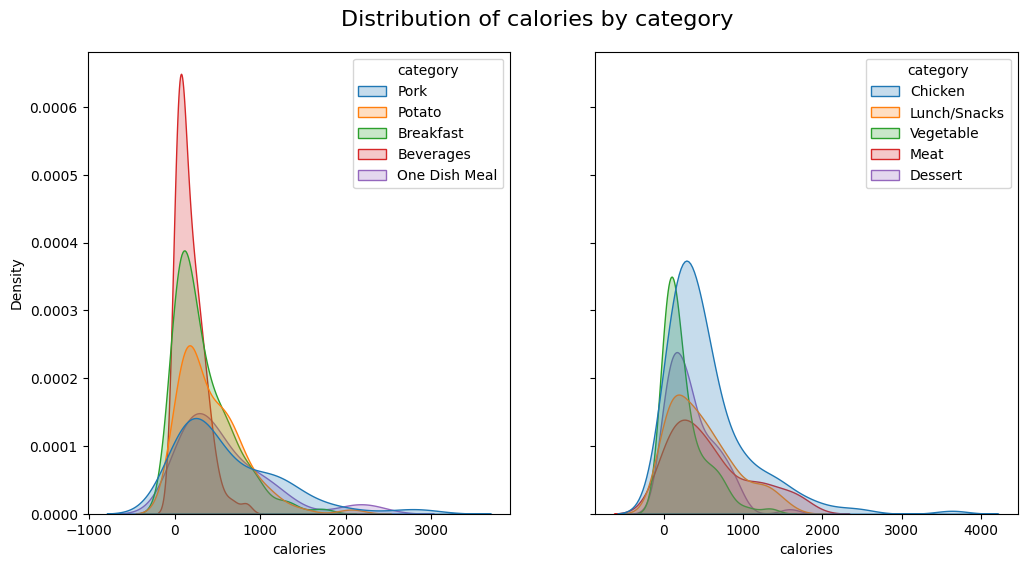

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


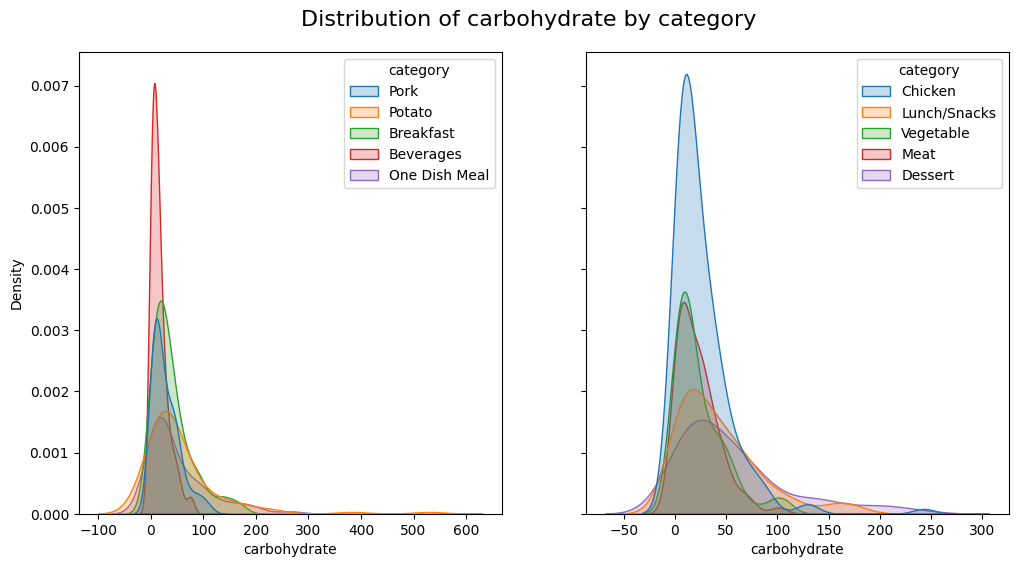

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


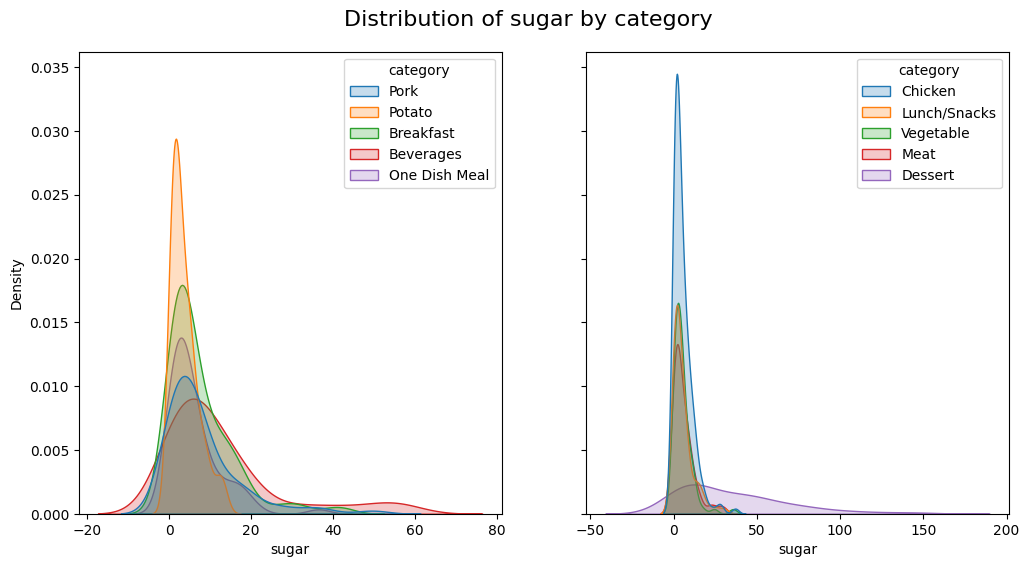

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


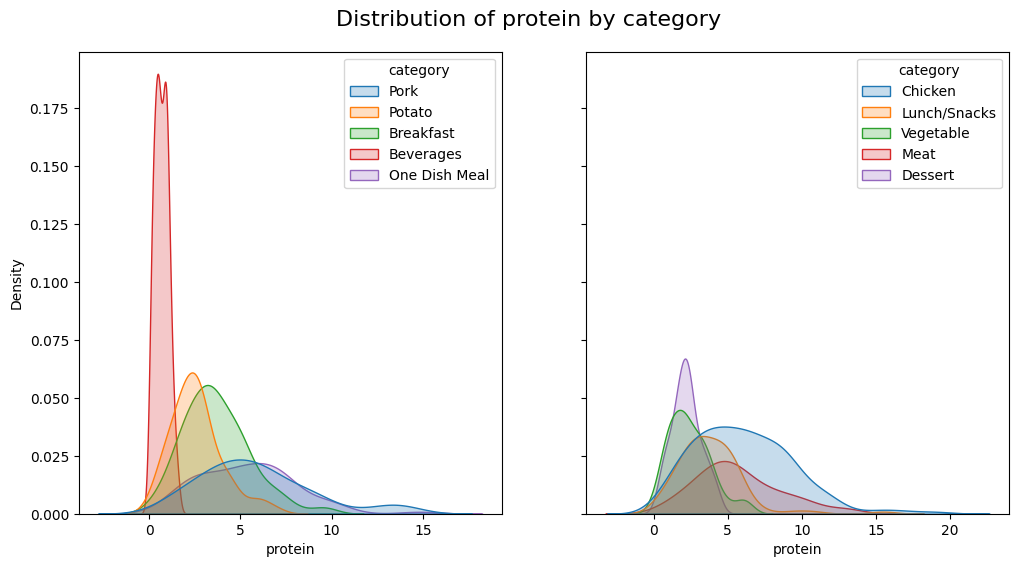

In [15]:
categories = recipe_data['category'].unique()
data_subset_1 = recipe_data[recipe_data['category'].isin(categories[:5])]
data_subset_2 = recipe_data[recipe_data['category'].isin(categories[5:])]
columns = ['calories', 'carbohydrate', 'sugar']
for column in columns:
    fig, axs = plt.subplots(1,2, figsize=(12,6), sharey = True)
    sns.kdeplot(data= data_subset_1, x = column, hue ='category', ax=axs[0], fill=True)
    sns.kdeplot(data= data_subset_2, x = column, hue ='category', ax=axs[1], fill=True)
    plt.suptitle(f'Distribution of {column} by category', y= 0.95, size=16)
    plt.show()

# Changing protein column to a square root scale to enhance visualization
fig, axs = plt.subplots(1,2, figsize=(12,6), sharey = True)
sns.kdeplot(data= data_subset_1, x = np.sqrt(data_subset_1['protein']), hue ='category', ax=axs[0], fill=True)
sns.kdeplot(data= data_subset_2, x =  np.sqrt(data_subset_2['protein']), hue ='category', ax=axs[1], fill=True)
plt.suptitle('Distribution of protein by category', y= 0.95, size=16)
plt.show()

As illustrated in the previous graph, a right-skewed distribution is evident among nutritional components in almost every category. Notably, the 'sugar' nutritional component in the Dessert category, as well as the 'protein' nutritional component in the One Dish Meal, Pork, Meat, and Chicken categories, do not exhibit a well-defined skewed distribution. 

## Count of categories

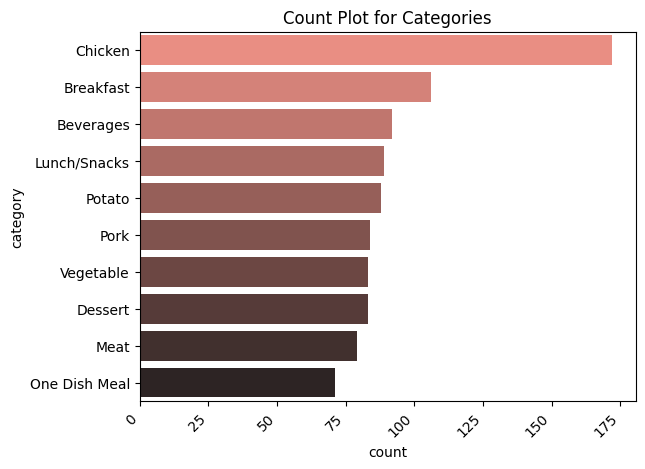

In [16]:
# Count of categories
sns.countplot(y='category', data=recipe_data, order= recipe_data['category'].value_counts().index, palette='dark:salmon_r')
plt.title('Count Plot for Categories')
plt.xticks(rotation = 45, ha='right')
plt.show()

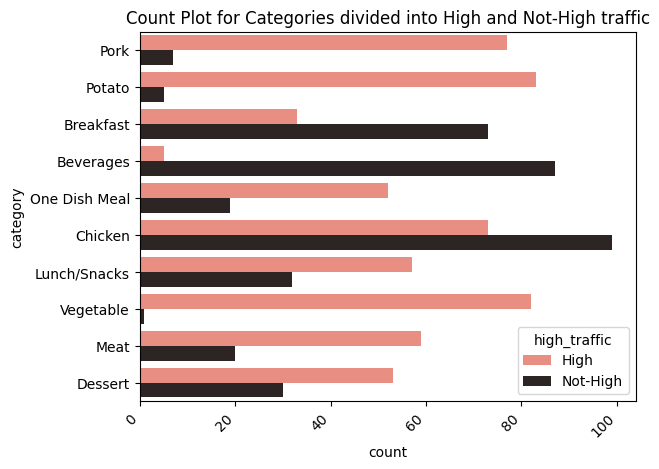

In [17]:
# Count of high traffic recipes by category
sns.countplot(y='category', data=recipe_data, palette='dark:salmon_r', hue='high_traffic')
plt.title('Count Plot for Categories divided into High and Not-High traffic')
plt.xticks(rotation = 45, ha='right')
plt.show()

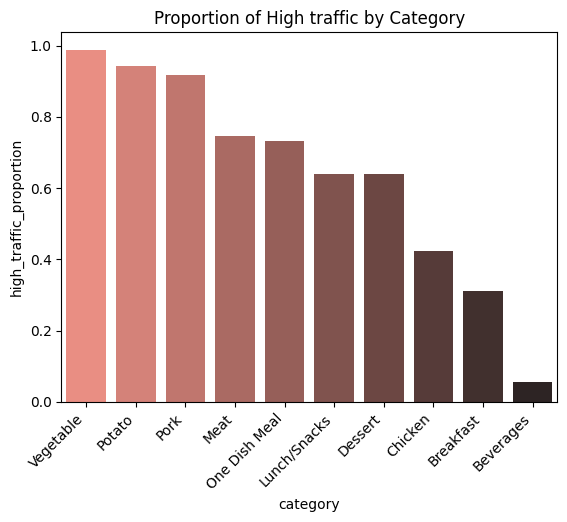

In [18]:
# Proportion of high traffic vs not-high traffic
high_traffic_data_by_cat = recipe_data.groupby(['category', 'high_traffic'])['high_traffic'].count().unstack()
high_traffic_data_by_cat['high_traffic_proportion'] = high_traffic_data_by_cat['High']/(high_traffic_data_by_cat['High'] + high_traffic_data_by_cat['Not-High'])
high_traffic_data_by_cat.sort_values(by='high_traffic_proportion', ascending=False, inplace=True)
sns.barplot(x=high_traffic_data_by_cat.index, y=high_traffic_data_by_cat['high_traffic_proportion'], palette='dark:salmon_r')
plt.title('Proportion of High traffic by Category')
plt.xticks(rotation=45, ha='right')
plt.show()

The above graphs illustrate that the Chicken, Breakfast, and Beverages categories rank as the top three with the most recipes in the dataset. However, it's important to note that these categories do not represent the ones with the highest number of recipes with high traffic. In contrast, the Vegetable, Potato, and Pork categories stand out, housing recipes that attract significant levels of traffic.

## Distribution of servings

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


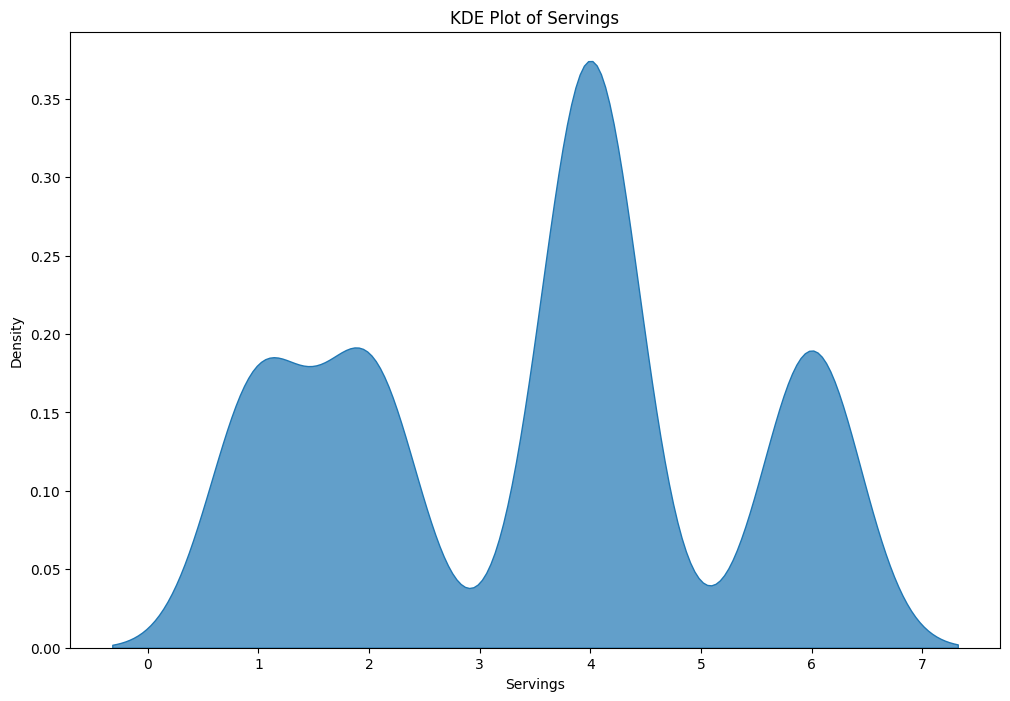

In [19]:
# KDE Distribution of servings
plt.figure(figsize=(12, 8))
sns.kdeplot(recipe_data['servings'], fill=True, alpha=0.7)
plt.title('KDE Plot of Servings')
plt.xlabel('Servings')
plt.ylabel('Density')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


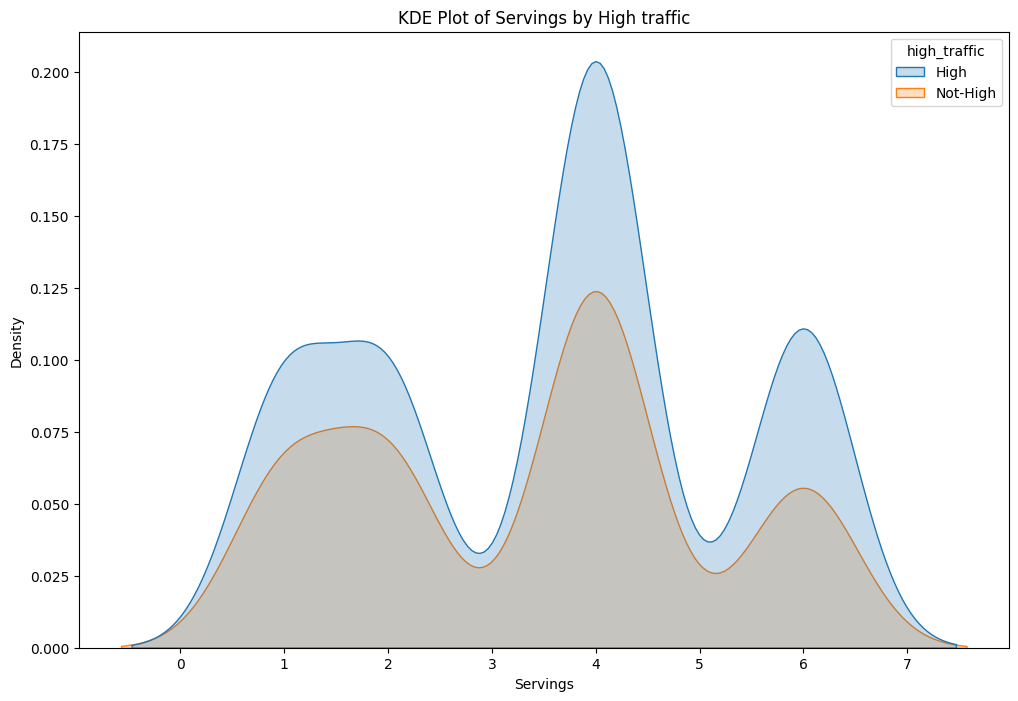

In [20]:
# KDE Distribution of servings by high traffic
plt.figure(figsize=(12, 8))
sns.kdeplot(data=recipe_data, x='servings', fill=True, hue='high_traffic')
plt.title('KDE Plot of Servings by High traffic')
plt.xlabel('Servings')
plt.ylabel('Density')
plt.show()

The dataset contains more recipes with 4 servings, while recipes with 1, 2, and 6 servings each have approximately equal counts. Notably, in the case of high-traffic recipes, those with 4 servings also have the maximum number of recipes.

### Serving by categories

In [21]:
# Setting color map for the categories
category_colors = {
    'Vegetable': '#008000',  
    'Chicken': '#FFC0CB',    
    'Pork': '#A52A2A',       
    'Meat': '#FF0000',       
    'Dessert': '#FF7F50',     
    'Potato': '#DEB887',      
    'Breakfast': '#0000FF',   
    'Beverages': '#FFA500',   
    'Lunch/Snacks': '#800080',
    'One Dish Meal': '#BA55D3' 
}

In [22]:
high_traffic = recipe_data[recipe_data['high_traffic'] == 'High']
high_traffic.sort_values(['servings','category'])

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
105,106,396.37,16.85,2.48,0.27,Beverages,1,High
24,25,1161.49,1.53,8.88,12.57,Breakfast,1,High
49,50,1724.25,45.52,0.07,49.37,Breakfast,1,High
79,80,19.91,35.47,2.17,11.82,Breakfast,1,High
189,190,529.68,23.75,2.28,15.81,Breakfast,1,High
...,...,...,...,...,...,...,...,...
481,482,392.95,103.46,4.97,1.06,Vegetable,6,High
582,583,451.79,19.64,4.16,5.37,Vegetable,6,High
665,666,643.87,0.70,35.74,12.96,Vegetable,6,High
685,686,73.30,7.73,3.95,36.47,Vegetable,6,High


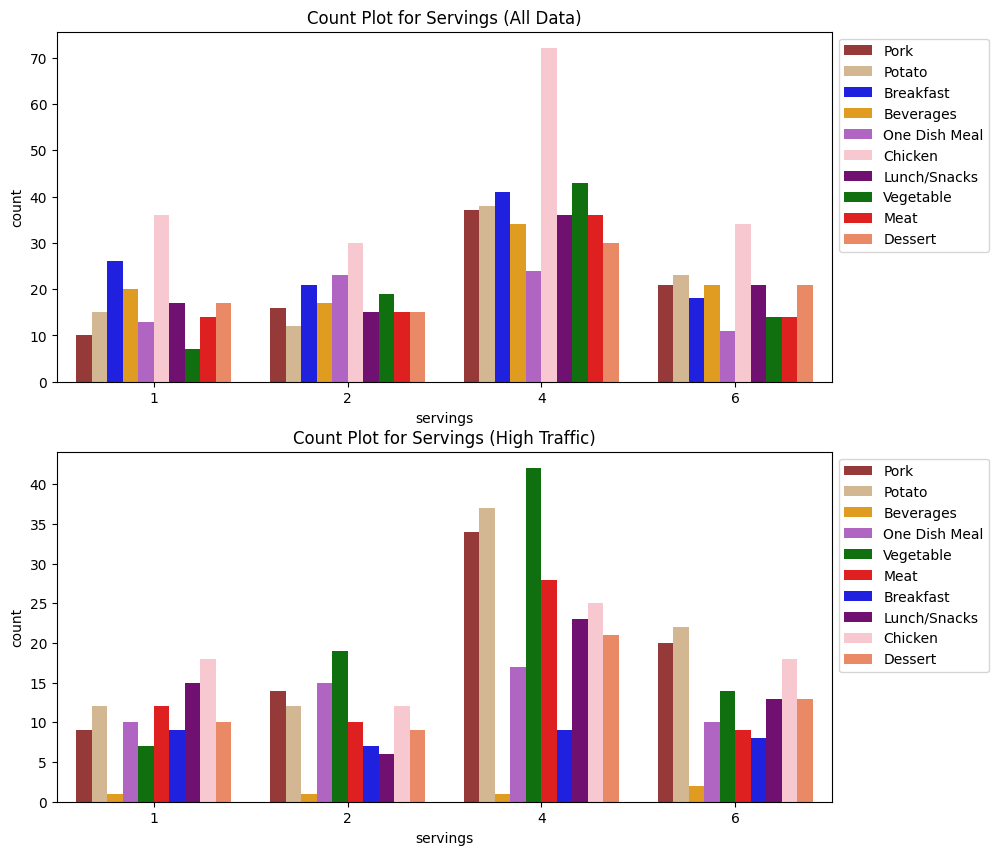

In [23]:
high_traffic = recipe_data[recipe_data['high_traffic'] == 'High']
palette = sns.color_palette("tab10", n_colors=len(recipe_data['category'].unique()))

fig, axs = plt.subplots(2,1, figsize=(10,10))
sns.countplot(x='servings', hue='category', data=recipe_data, ax=axs[0], palette=category_colors)
axs[0].set_title('Count Plot for Servings (All Data)')
axs[0].legend(loc='upper left', bbox_to_anchor=(1, 1))

sns.countplot(x='servings', hue='category', data=high_traffic, ax=axs[1], palette=category_colors)
axs[1].set_title('Count Plot for Servings (High Traffic)')
axs[1].legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

Upon closer examination of recipes categorized by servings and counted by category, it became evident that users seeking recipes with four servings are particularly interested in the Vegetable, Potato, and Pork categories. For those desiring recipes with one serving, preferences lean towards Chicken, Lunch/Snacks, Meat, and Potato. Recipes with two servings attract interest in the Vegetable, One Dish Meal, and Pork categories. Additionally, those looking for recipes with six servings tend to prefer the Potato, Pork, and Chicken categories.

## Checking outliers by category

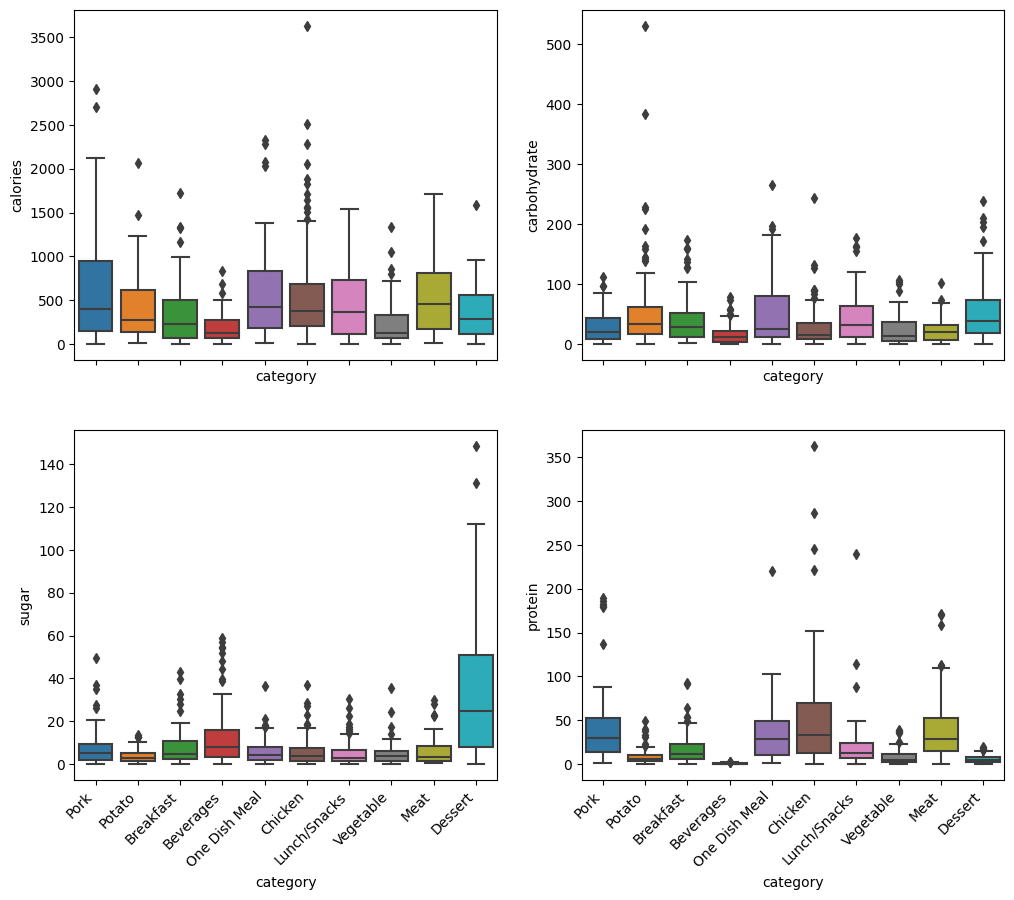

In [24]:
fig, axs = plt.subplots(2,2, figsize=(12, 10), sharex=True)
sns.boxplot(data=recipe_data, x='category', y='calories', ax=axs[0,0])
sns.boxplot(data=recipe_data, x='category', y='carbohydrate', ax=axs[0,1])
sns.boxplot(data=recipe_data, x='category', y='sugar', ax=axs[1,0])
sns.boxplot(data=recipe_data, x='category', y='protein', ax=axs[1,1])
axs[1,0].set_xticklabels(axs[1,0].get_xticklabels(), rotation=45, ha='right')
axs[1,1].set_xticklabels(axs[1,1].get_xticklabels(), rotation=45, ha='right')
plt.show()

## Relationship between numerical columns

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

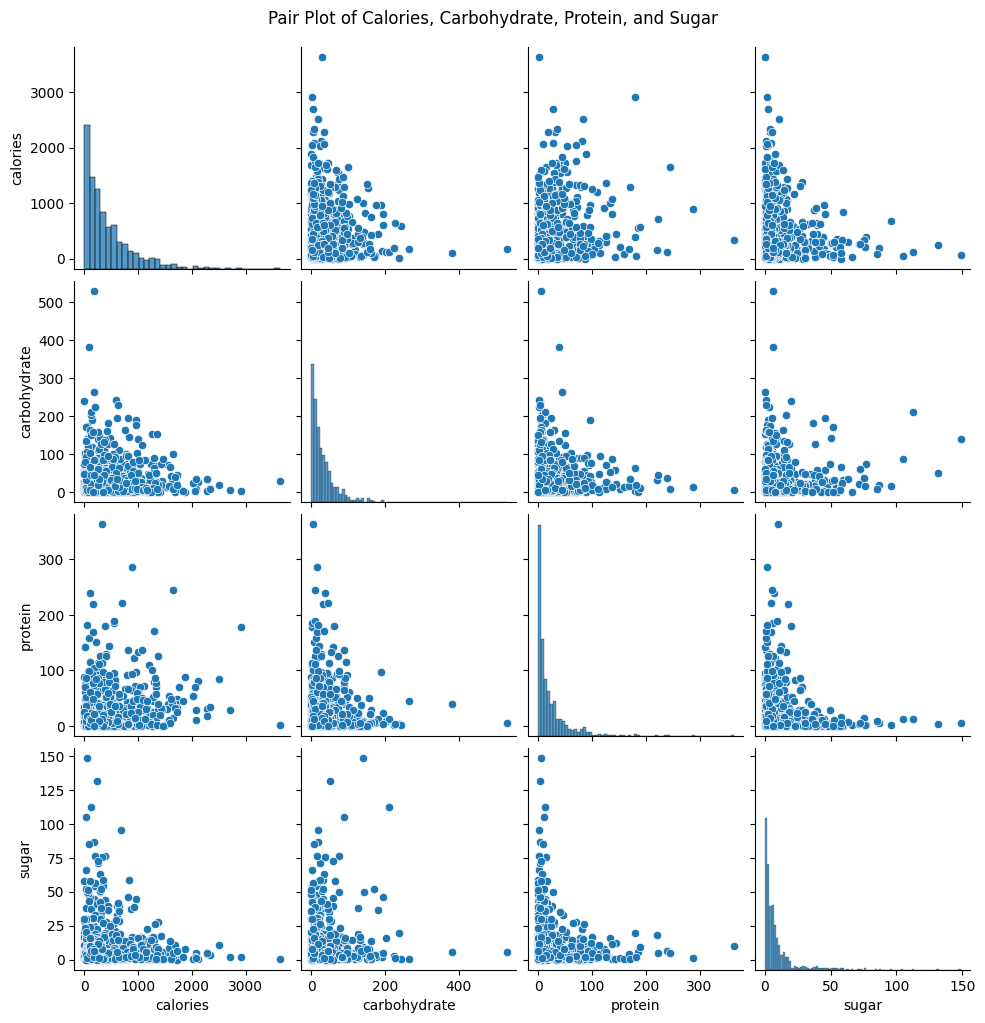

In [25]:
# Create a pair plot
sns.pairplot(recipe_data[['calories', 'carbohydrate', 'protein', 'sugar']])
plt.suptitle('Pair Plot of Calories, Carbohydrate, Protein, and Sugar', y=1.02)
plt.show()

The dataset has no clear relationship between any combination of calories, carbohydrates, protein, and sugar. Therefore, I will explore further the relationship between these nutritional components for each category.

### Relationship between nutritional components for each category

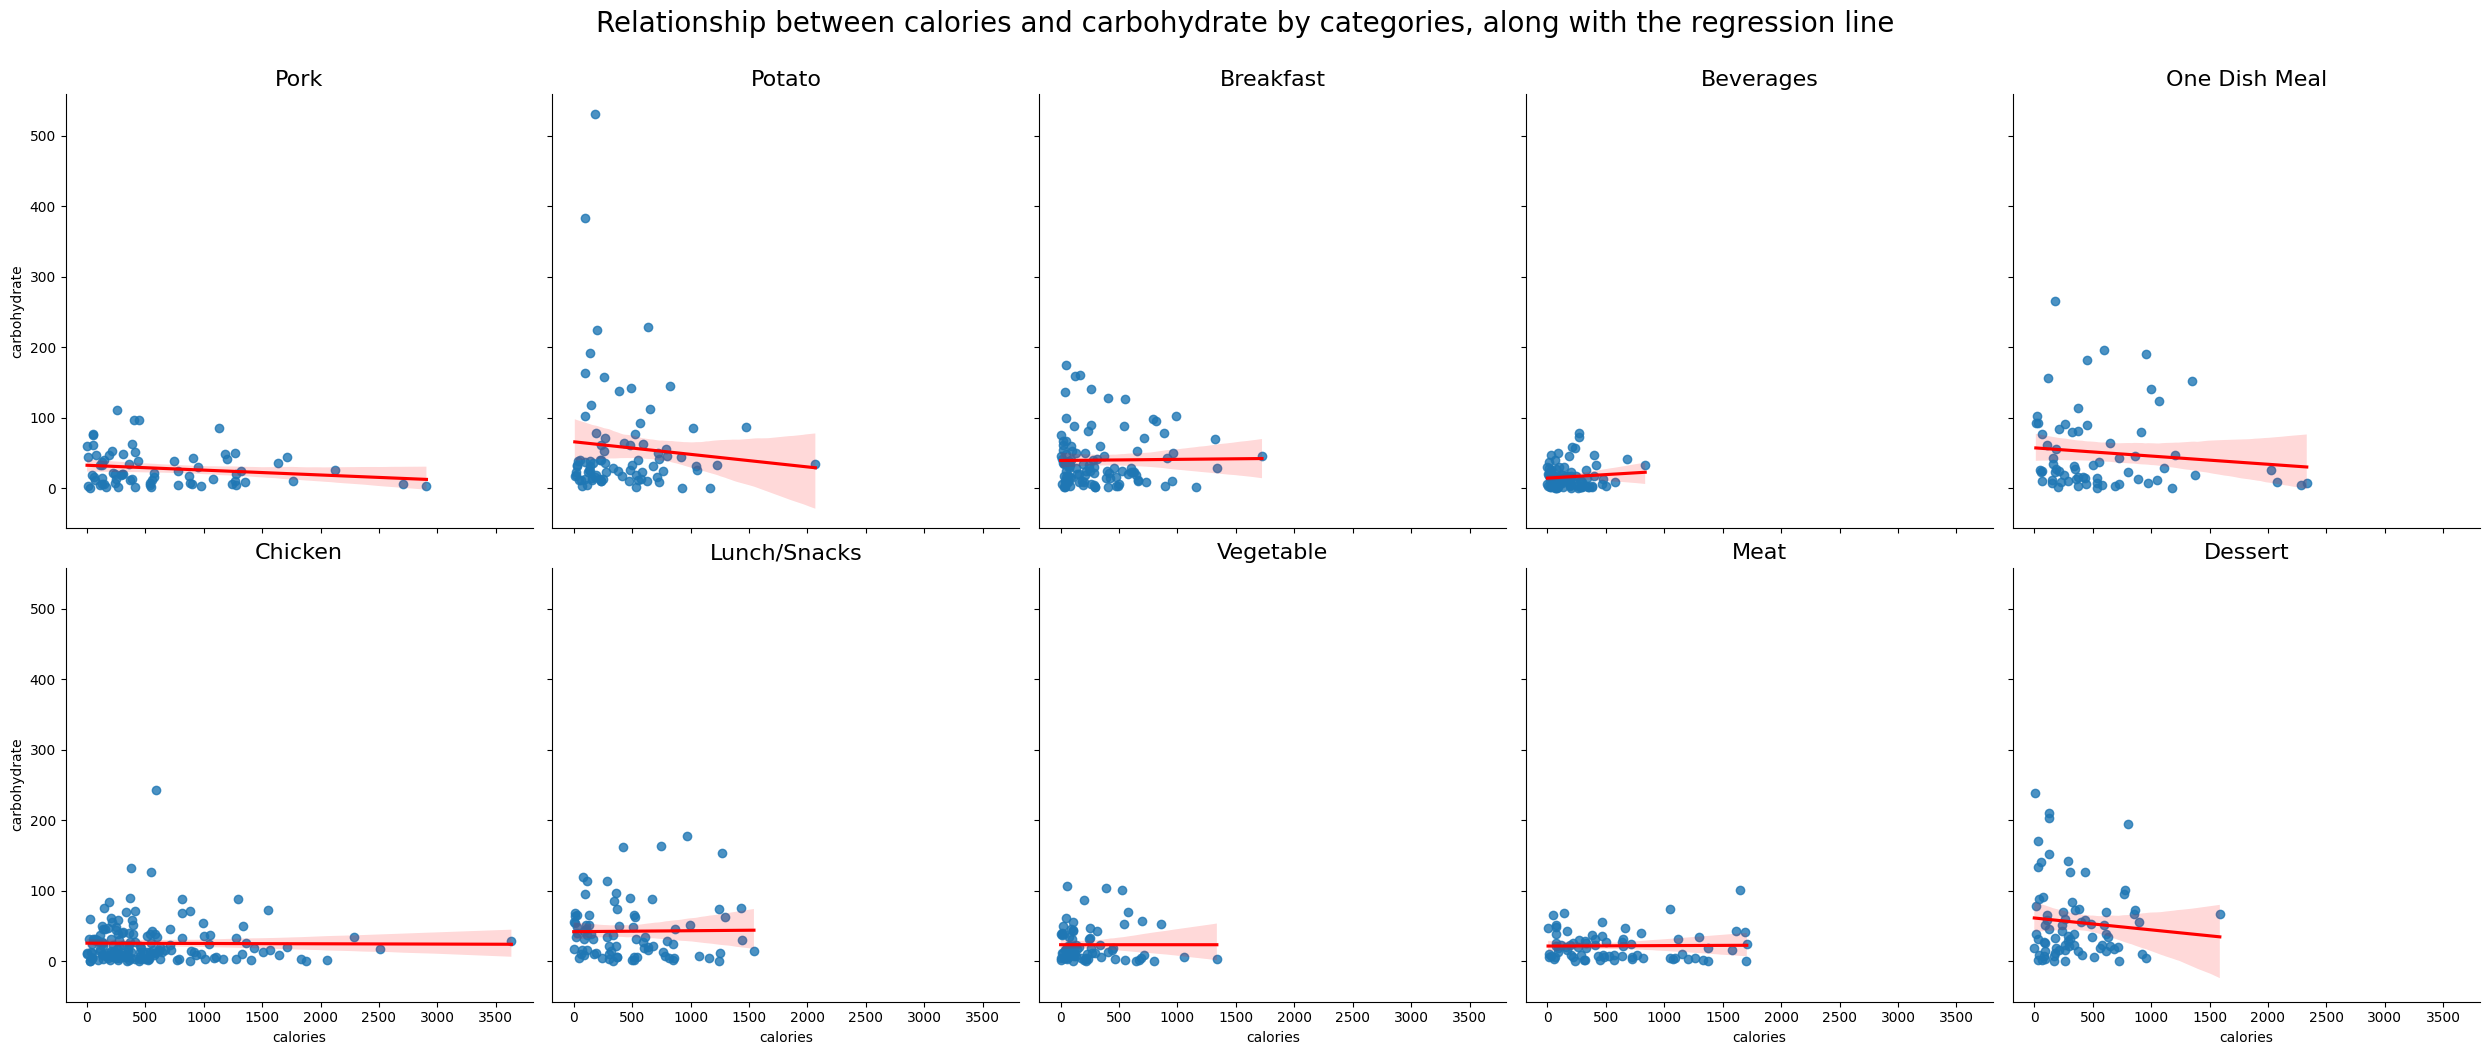

In [26]:
sns.lmplot(data= recipe_data, x= 'calories', y= 'carbohydrate', line_kws={'color': 'red'}, col= 'category', col_wrap=5).set_titles(template="{col_name}",size=16)            
plt.suptitle("Relationship between calories and carbohydrate by categories, along with the regression line", fontsize=20, y=1.05)
plt.show()

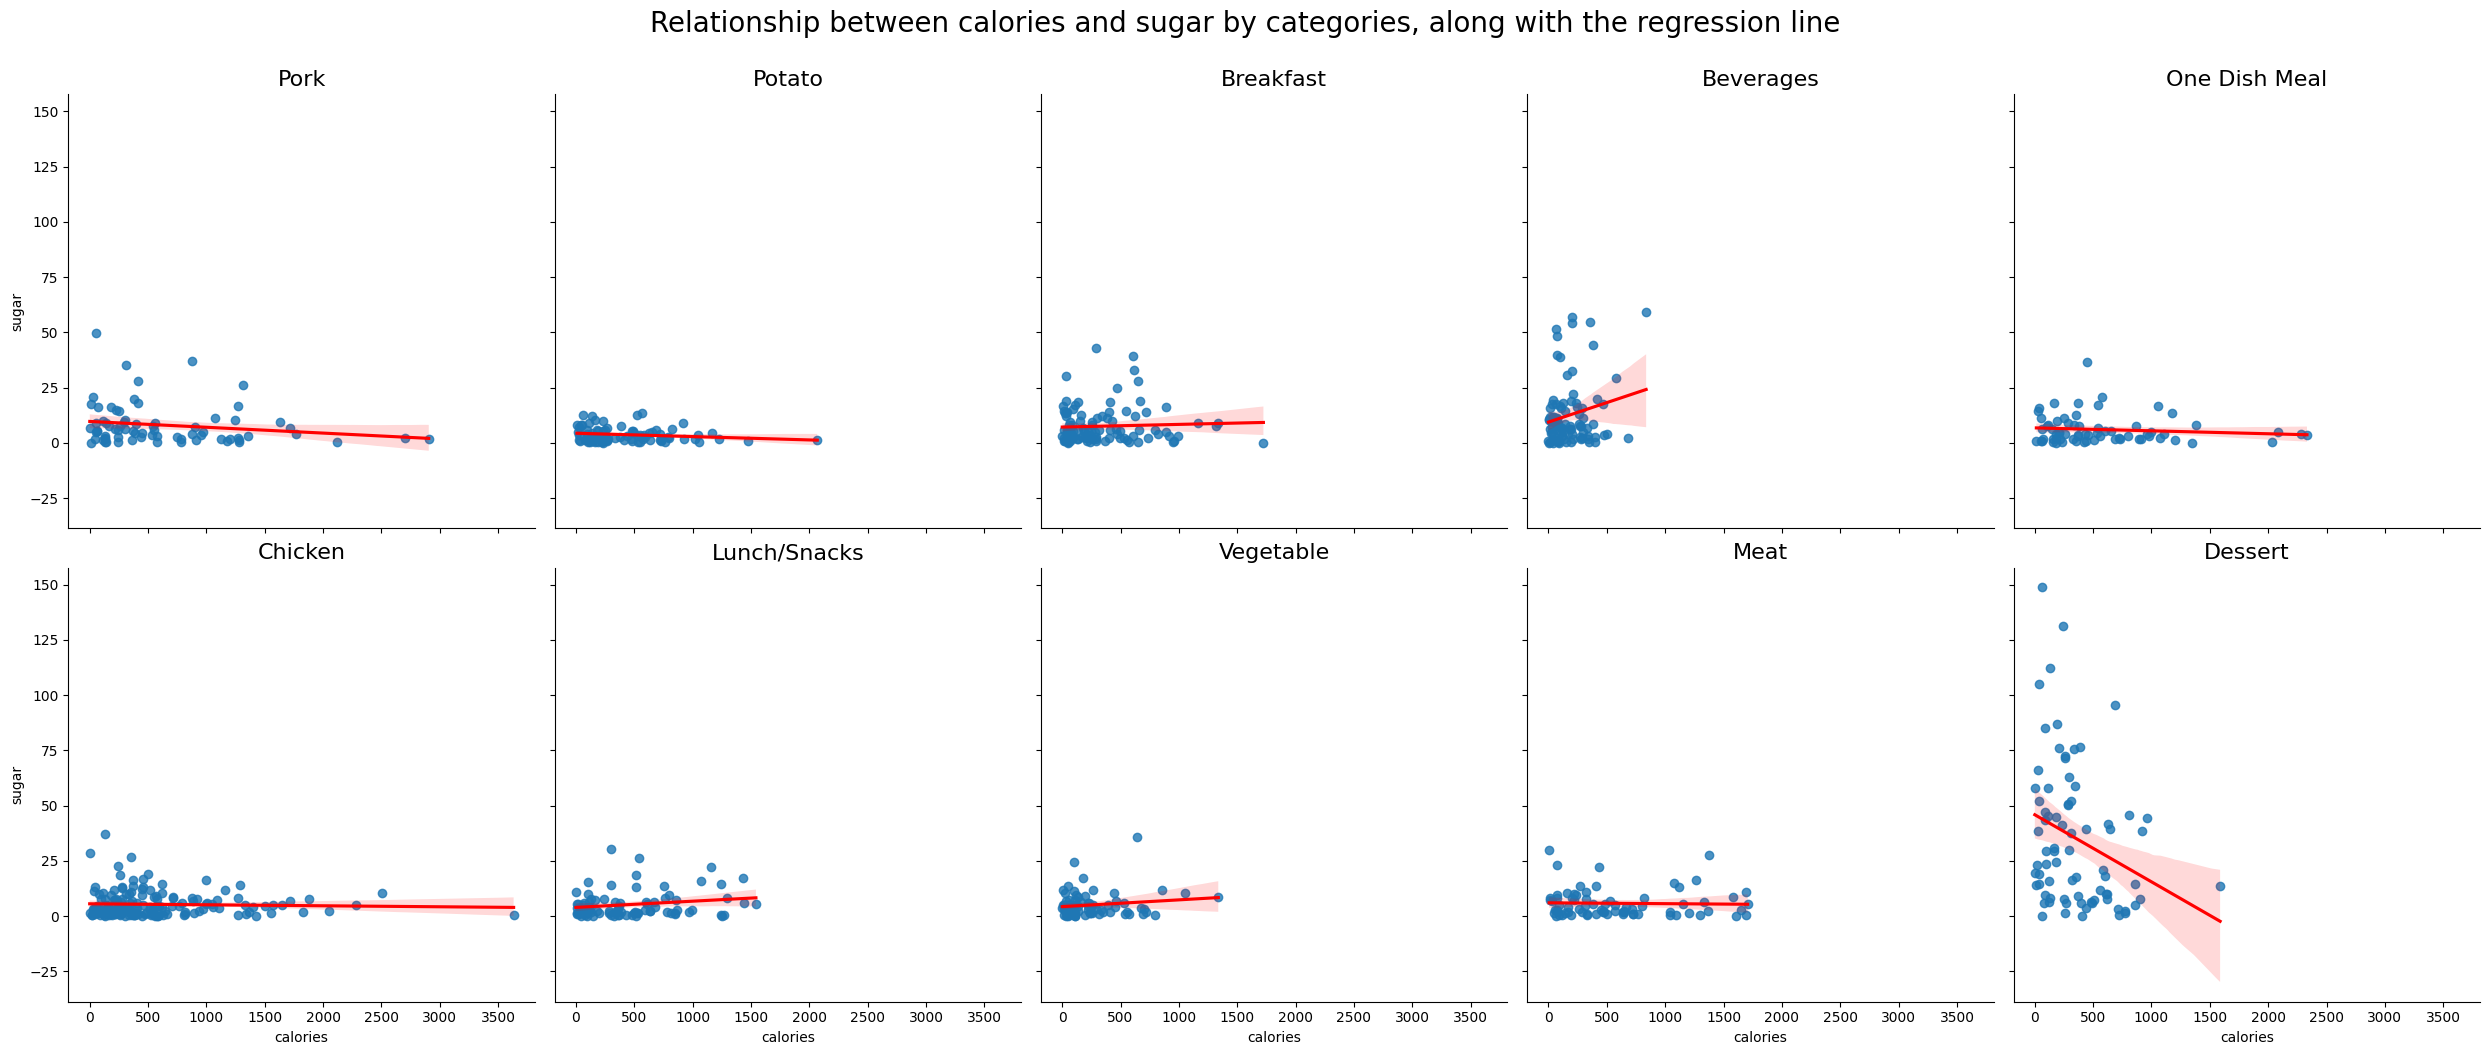

In [27]:
sns.lmplot(data= recipe_data, x= 'calories', y= 'sugar', line_kws={'color': 'red'}, col= 'category', col_wrap=5).set_titles(template="{col_name}",size=16)            
plt.suptitle("Relationship between calories and sugar by categories, along with the regression line", fontsize=20, y=1.05)
plt.show()

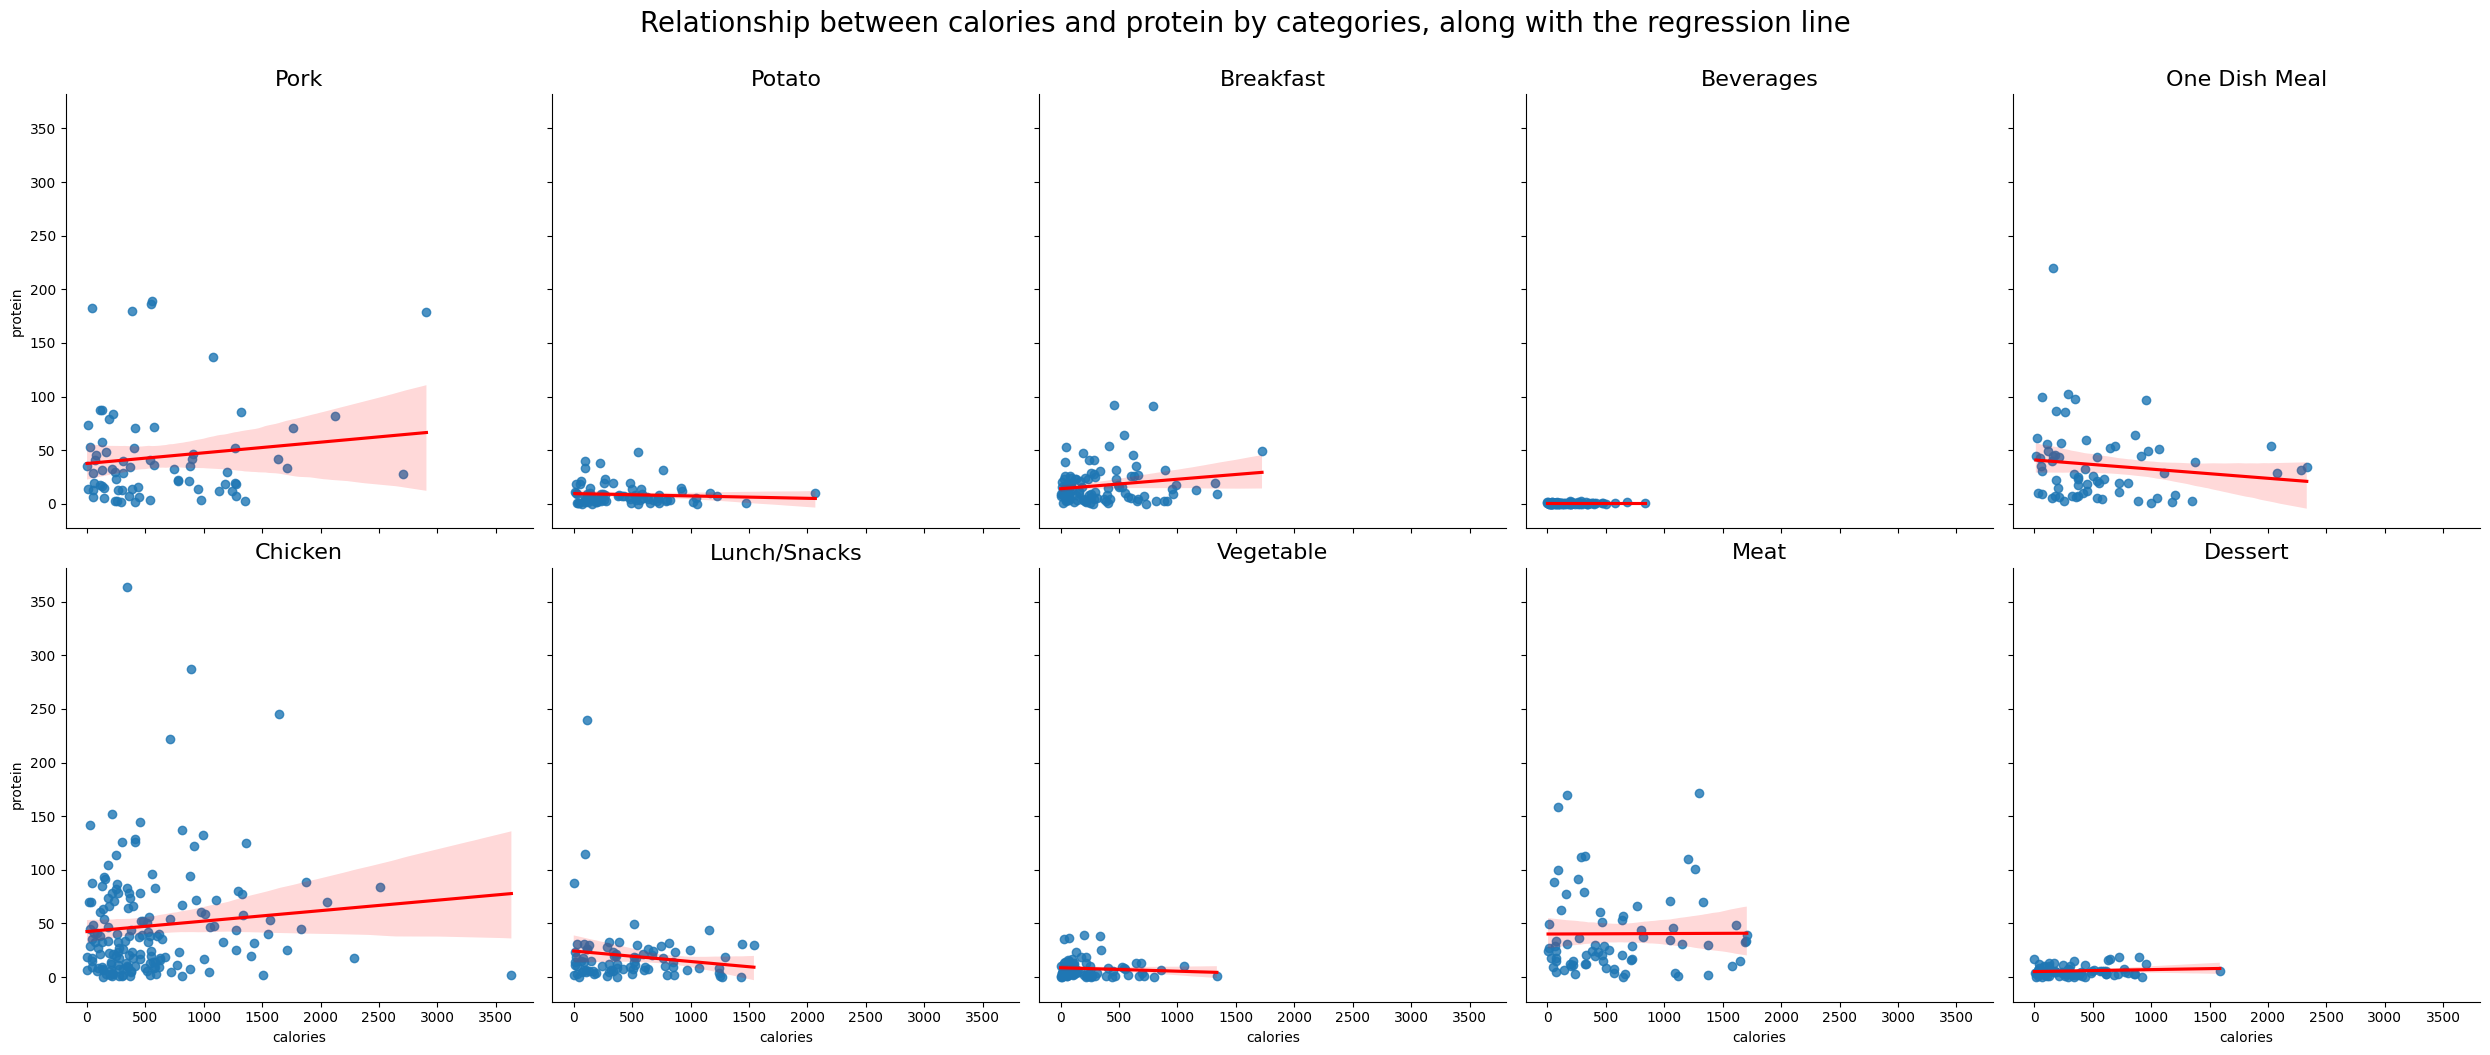

In [28]:
sns.lmplot(data= recipe_data, x= 'calories', y= 'protein', line_kws={'color': 'red'}, col= 'category', col_wrap=5).set_titles(template="{col_name}",size=16)            
plt.suptitle("Relationship between calories and protein by categories, along with the regression line", fontsize=20, y=1.05)
plt.show()

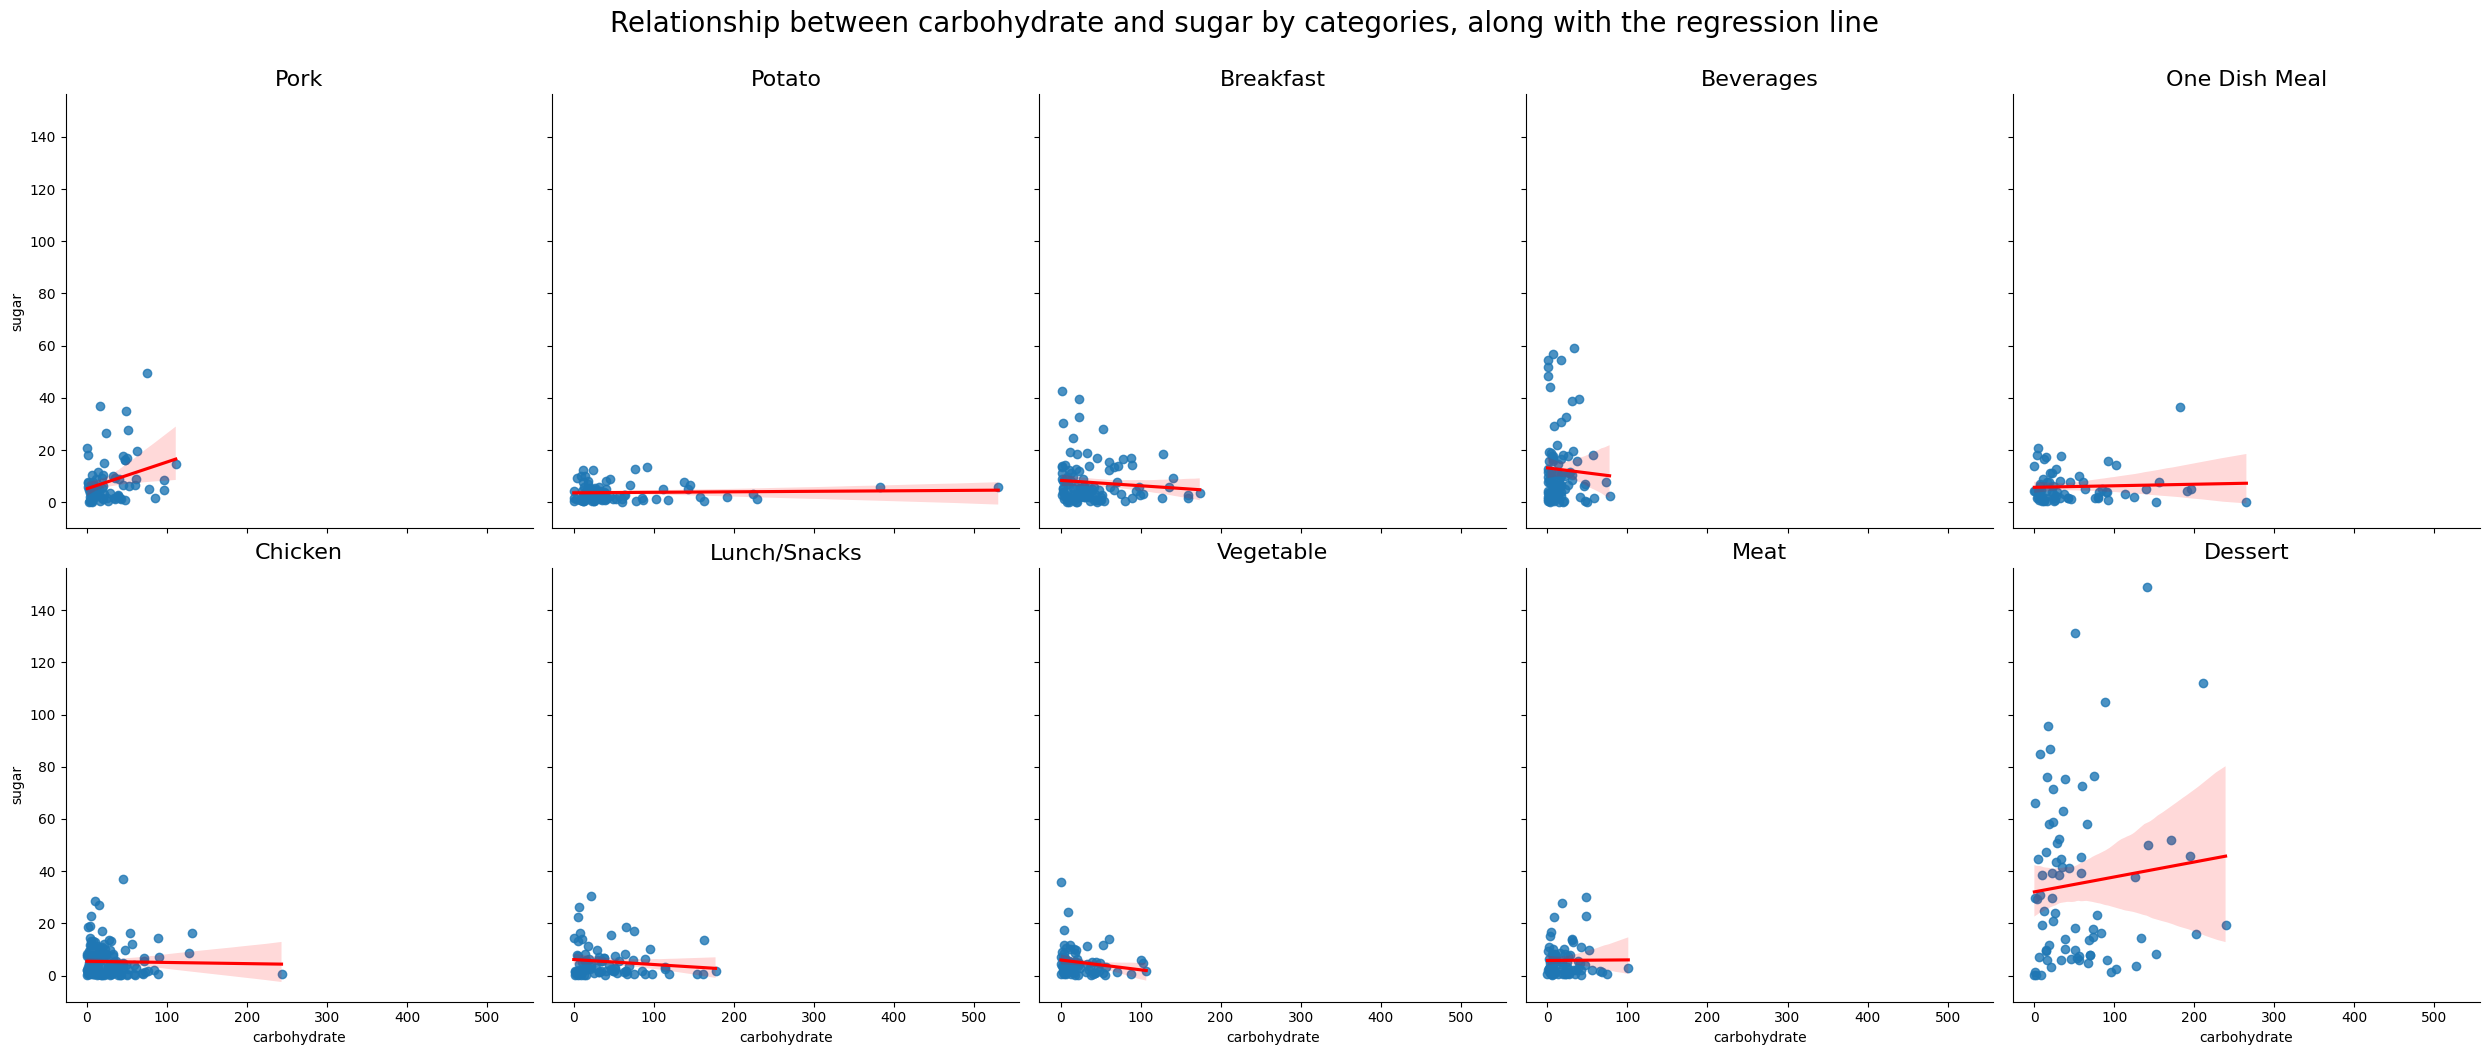

In [29]:
sns.lmplot(data= recipe_data, x= 'carbohydrate', y= 'sugar', line_kws={'color': 'red'}, col= 'category', col_wrap=5).set_titles(template="{col_name}",size=16)            
plt.suptitle("Relationship between carbohydrate and sugar by categories, along with the regression line", fontsize=20, y=1.05)
plt.show()

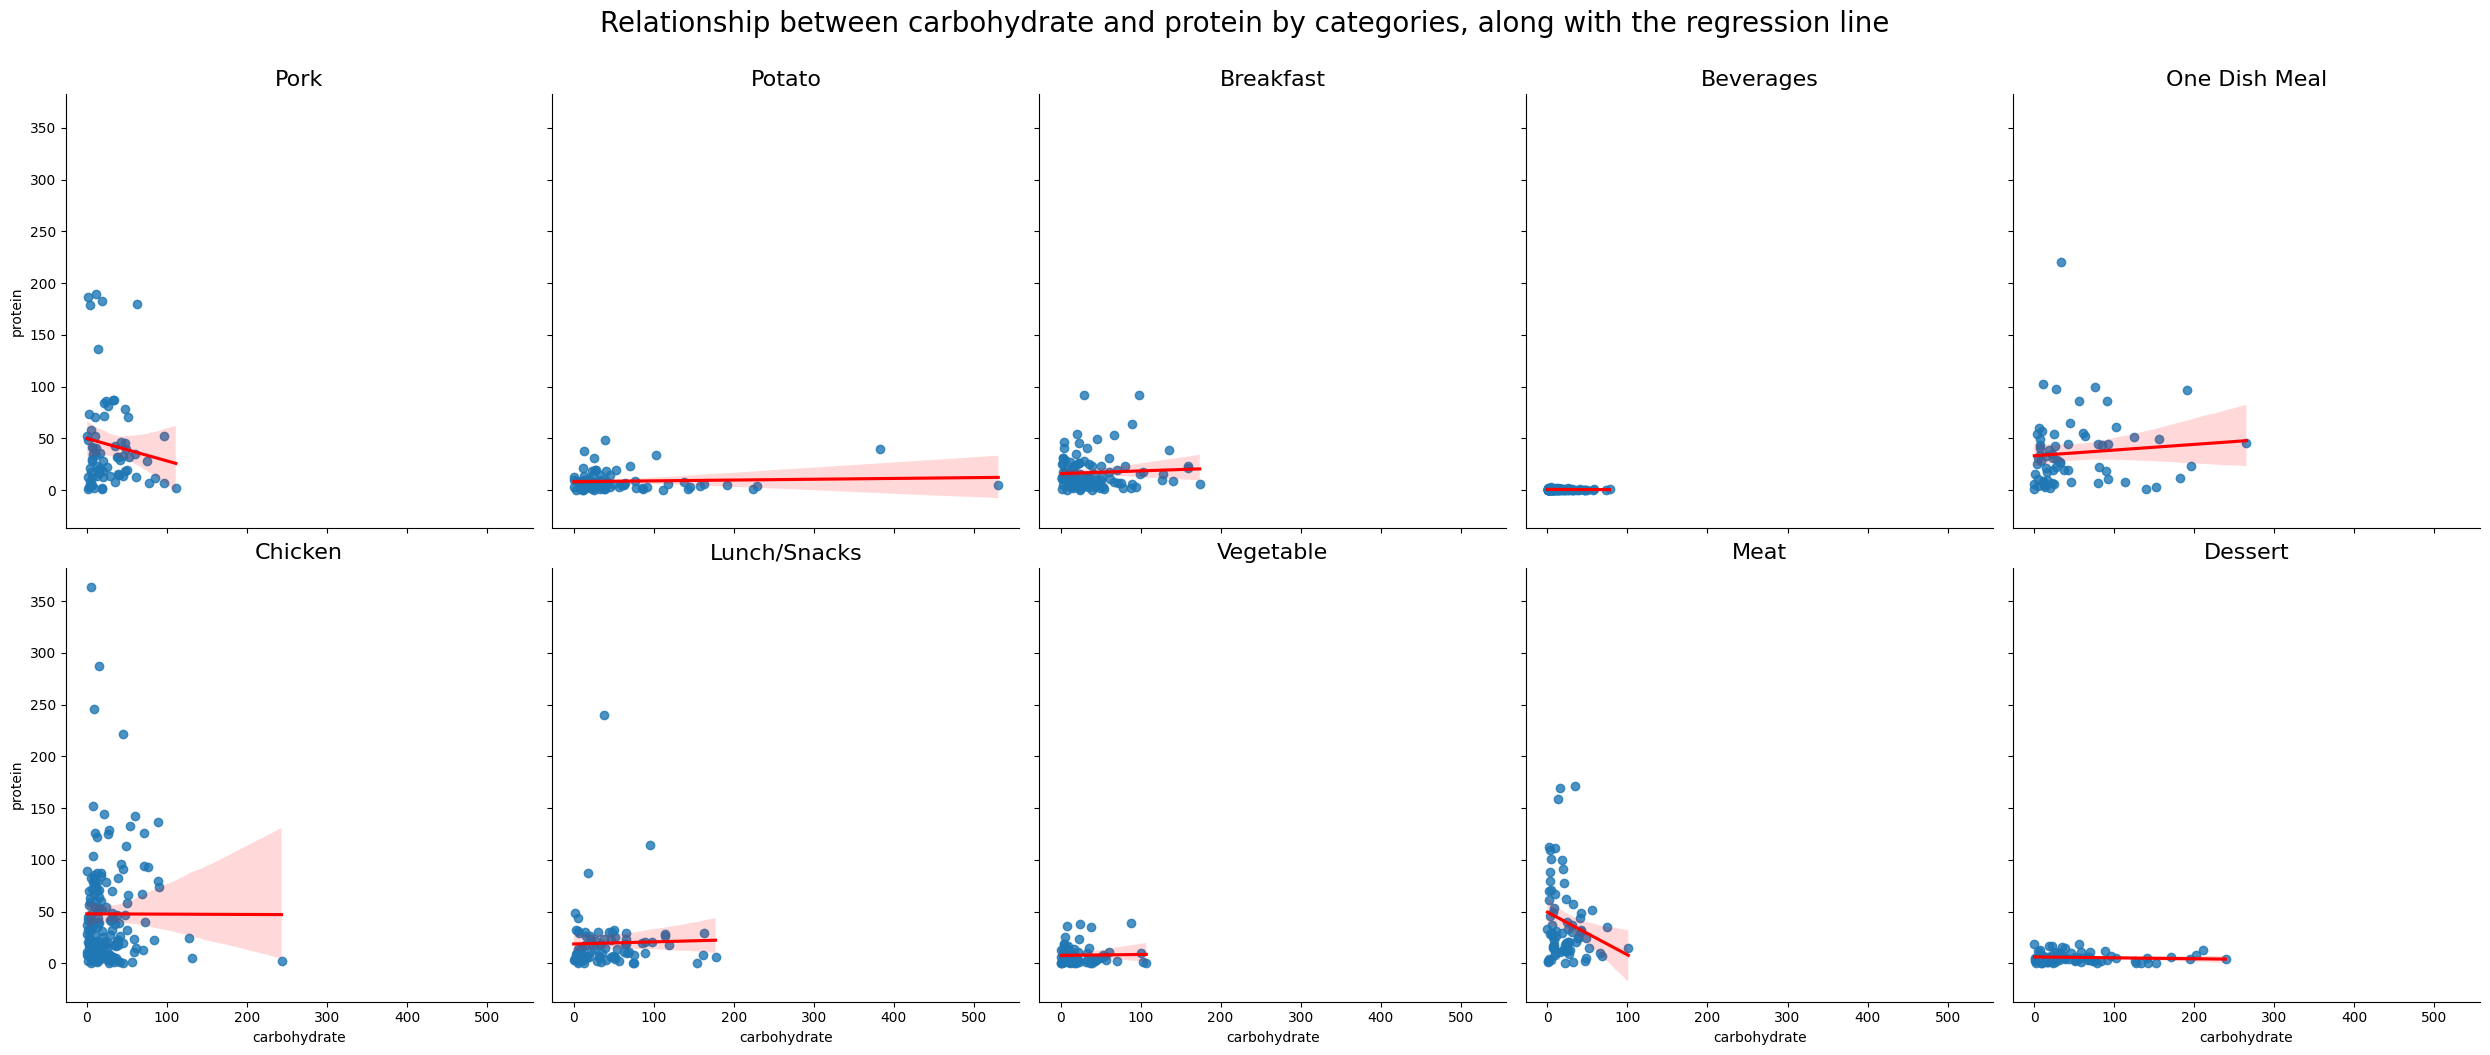

In [30]:
sns.lmplot(data= recipe_data, x= 'carbohydrate', y= 'protein', line_kws={'color': 'red'}, col= 'category', col_wrap=5).set_titles(template="{col_name}",size=16)            
plt.suptitle("Relationship between carbohydrate and protein by categories, along with the regression line", fontsize=20, y=1.05)
plt.show()

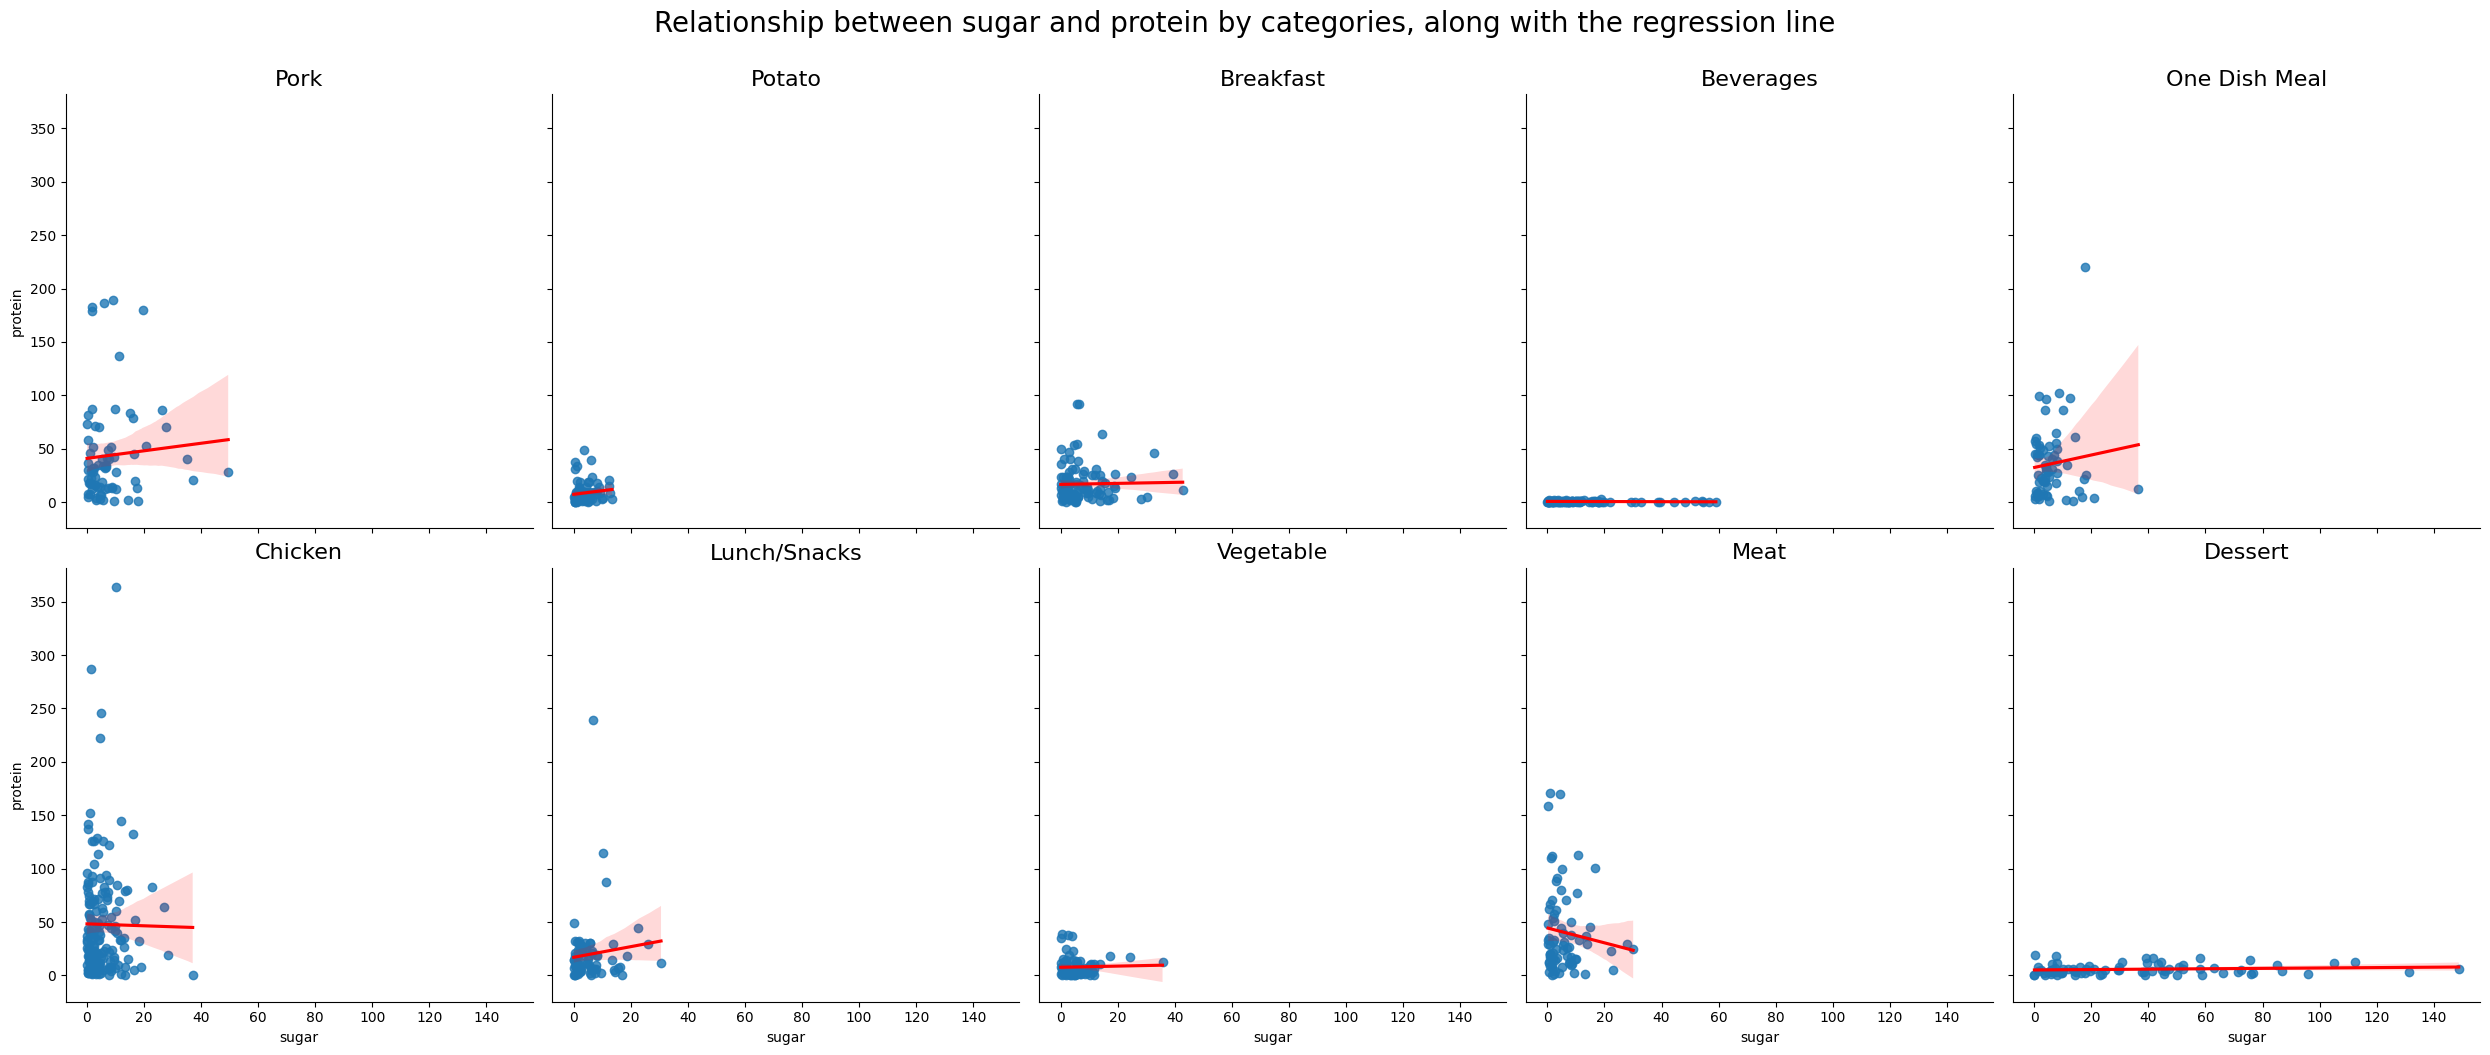

In [31]:
sns.lmplot(data= recipe_data, x= 'sugar', y= 'protein', line_kws={'color': 'red'}, col= 'category', col_wrap=5).set_titles(template="{col_name}",size=16)            
plt.suptitle("Relationship between sugar and protein by categories, along with the regression line", fontsize=20, y=1.05)
plt.show()

The dataset has no clear relationship between any combination of calories, carbohydrates, protein, and sugar divided by categories.

## Interesting in recipes by nutritional component

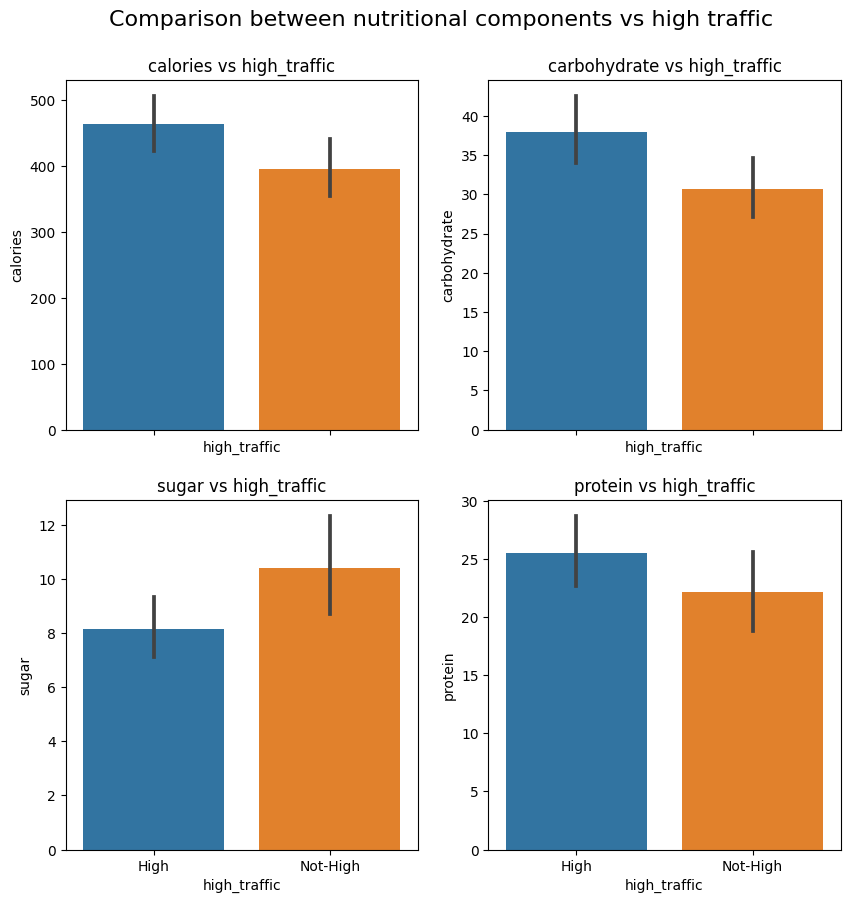

In [32]:
fig, axs = plt.subplots(2,2, figsize=(10,10), sharex=True)
sns.barplot(data = recipe_data, x="high_traffic", y='calories', ax=axs[0,0])
sns.barplot(data = recipe_data, x="high_traffic", y='carbohydrate', ax=axs[0,1])
sns.barplot(data = recipe_data, x="high_traffic", y='sugar', ax=axs[1,0])
sns.barplot(data = recipe_data, x="high_traffic", y='protein', ax=axs[1,1])
axs[0,0].set_title('calories vs high_traffic')
axs[0,1].set_title('carbohydrate vs high_traffic')
axs[1,0].set_title('sugar vs high_traffic')
axs[1,1].set_title('protein vs high_traffic')
plt.suptitle('Comparison between nutritional components vs high traffic', y=0.95, size=16)
plt.show()

There appears to be a preference for recipes with low sugar content, but there is not enough evidence to draw a significant conclusion from these insights.

# Handling missing values

In [33]:
# Checking missing values
recipe_data.isna().sum()

recipe           0
calories        52
carbohydrate    52
sugar           52
protein         52
category         0
servings         0
high_traffic     0
dtype: int64

## Imputation of the missing values by category

As the majority of categories exhibit a right-skewed distribution in calories, carbohydrates, sugar, and protein, I have decided to impute missing values with the median. This choice takes into account the presence of high values (outliers) in specific categories. Additionally, for categories without a well-defined skewed distribution, as mentioned earlier, I opt to impute missing values with the mean.

In [34]:
def mean_impute(df, column, category):
    '''
        Imputing missing values with mean in the dataset column (column) and the category (category)
    '''
    missing_values = df[df[column].isna()] 
    median_column_by_cat = df.groupby('category')[column].mean()
    missing_categories = missing_values['category'].value_counts().index
    miss_values_by_cat = missing_values.loc[missing_values['category'] == category, column]
    miss_values_by_cat.fillna(median_column_by_cat[category],inplace=True)
    df.loc[miss_values_by_cat.index,column] = miss_values_by_cat
    return df

In [35]:
def median_impute(df, column):
    '''
        Imputing missing values with median in the dataset column (column)
    '''
    missing_values = df[df[column].isna()]    
    median_column_by_cat = df.groupby('category')[column].median()
    missing_categories = missing_values['category'].value_counts().index
    for category in missing_categories:
        miss_values_by_cat = missing_values.loc[missing_values['category'] == category, column]        
        miss_values_by_cat.fillna(median_column_by_cat[category],inplace=True)
        df.loc[miss_values_by_cat.index,column] = miss_values_by_cat
    return df

In [36]:
cleaned_data = recipe_data.set_index('recipe')
target_column = ['calories', 'carbohydrate', 'sugar', 'protein']
cleaned_data = mean_impute(cleaned_data, 'sugar', 'Dessert')
cleaned_data = mean_impute(cleaned_data, 'protein', 'One Dish Meal')
cleaned_data = mean_impute(cleaned_data, 'protein', 'Pork')
cleaned_data = mean_impute(cleaned_data, 'protein', 'Chicken')
cleaned_data = mean_impute(cleaned_data, 'protein', 'Meat')
for column in target_column:
    cleaned_data = median_impute(cleaned_data, column)

In [37]:
cleaned_data.isna().sum()

calories        0
carbohydrate    0
sugar           0
protein         0
category        0
servings        0
high_traffic    0
dtype: int64

# Fitting and Evaluating Models 

## Preprocessing data

**Converting category column to dummies**

Given the substantial presence of outliers in the dataset, there's a potential impact on the model's performance. It's crucial to address this issue by employing a robust scaler for data scaling, as traditional scalers based on mean and standard deviation are susceptible to the influence of outliers.

In [38]:
encoded_categories = pd.get_dummies(cleaned_data['category'], prefix='category').astype(int)
encoded_cleaned_data = pd.concat([cleaned_data.drop(columns=['category']), encoded_categories], axis=1)

X = encoded_cleaned_data.drop(columns=['high_traffic'])
y_ = encoded_cleaned_data['high_traffic']
y = np.where(y_=='High', 1, 0)
rs = RobustScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaled_X_train = rs.fit_transform(X_train)
scaled_X_test = rs.transform(X_test)

## Baseline model

In [39]:
gb_model = GradientBoostingClassifier()

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3],
    'random_state': [42]    
}
gb_grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, scoring='accuracy', cv=10, n_jobs=-1)
gb_grid_search.fit(scaled_X_train, y_train)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


GridSearchCV(cv=10, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5], 'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [50, 100, 200], 'random_state': [42]},
             scoring='accuracy')

Best hyperparameters: {'learning_rate': 0.01, 'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 200, 'random_state': 42}
Accuracy of the Gradient Boosting Classifier: 0.7421052631578947


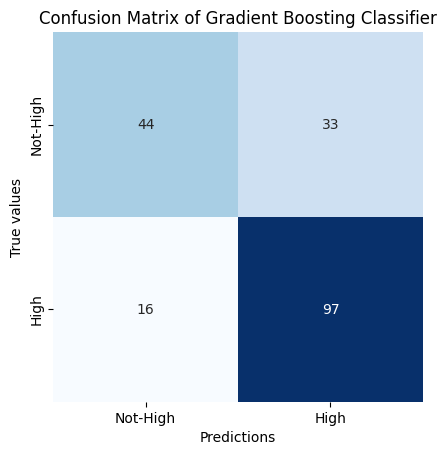

Classification report of Gradient Boosting Classifier: 
              precision    recall  f1-score   support

           0       0.73      0.57      0.64        77
           1       0.75      0.86      0.80       113

    accuracy                           0.74       190
   macro avg       0.74      0.71      0.72       190
weighted avg       0.74      0.74      0.74       190



In [42]:
best_gb_model = gb_grid_search.best_estimator_
print("Best hyperparameters:", gb_grid_search.best_params_)

# Predicting using the best model founded
y_pred_gb = best_gb_model.predict(scaled_X_test)

# Calculating accuracy
accuracy = accuracy_score(y_test, y_pred_gb)
print("Accuracy of the Gradient Boosting Classifier:", accuracy)

cm = confusion_matrix(y_test, y_pred_gb)
# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, square=True,
            xticklabels=['Not-High', 'High'],
            yticklabels=['Not-High', 'High'])

plt.xlabel('Predictions')
plt.ylabel('True values')
plt.title('Confusion Matrix of Gradient Boosting Classifier')

plt.show()
print('Classification report of Gradient Boosting Classifier: ')
print(classification_report(y_test, y_pred_gb))

The following models are implemented as a comparison:
- LogisticRegression
- RandomForestClassifier
- KNeighborsClassifier
- SupportVectorMachineClassifier (SVC)

## Comparison models

#### RandomForestClassifier

In [43]:
rf_model = RandomForestClassifier()

params = {
    'n_estimators': [50, 100, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False],
    'random_state': [42]
}
rf_grid_search = GridSearchCV(estimator=rf_model, param_grid=params, scoring='accuracy', cv=10, n_jobs=-1)
rf_grid_search.fit(scaled_X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 20, 30],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200], 'random_state': [42]},
             scoring='accuracy')

Best hyperparameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100, 'random_state': 42}
Accuracy of the Random Forest Model: 0.7210526315789474


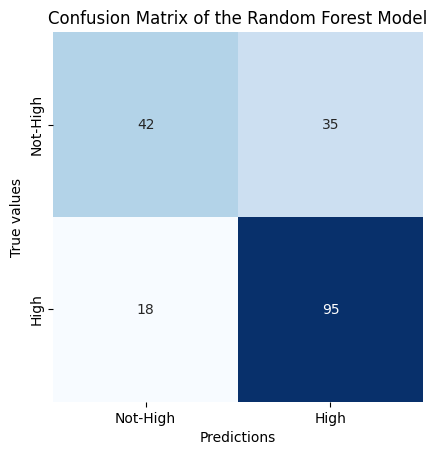

Classification report of the Random Forest Model: 
              precision    recall  f1-score   support

           0       0.70      0.55      0.61        77
           1       0.73      0.84      0.78       113

    accuracy                           0.72       190
   macro avg       0.72      0.69      0.70       190
weighted avg       0.72      0.72      0.71       190



In [44]:
best_rf_model = rf_grid_search.best_estimator_
print("Best hyperparameters:", rf_grid_search.best_params_)

# Predicting using the best model founded
y_pred_rf = best_rf_model.predict(scaled_X_test)

# Calculating accuracy
accuracy = accuracy_score(y_test, y_pred_rf)
print("Accuracy of the Random Forest Model:", accuracy)

cm = confusion_matrix(y_test, y_pred_rf)
# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, square=True,
            xticklabels=['Not-High', 'High'],
            yticklabels=['Not-High', 'High'])

plt.xlabel('Predictions')
plt.ylabel('True values')
plt.title('Confusion Matrix of the Random Forest Model')

plt.show()
print('Classification report of the Random Forest Model: ')
print(classification_report(y_test, y_pred_rf))

#### Logistic Regression

In [45]:
logistic_model = LogisticRegression()

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    "multi_class": ["auto", "ovr", "multinomial"],
    "random_state": [42]
}
logistic_grid_search = GridSearchCV(estimator=logistic_model, param_grid=param_grid, scoring='accuracy', cv=10, n_jobs=-1)
logistic_grid_search.fit(scaled_X_train, y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'multi_class': ['auto', 'ovr', 'multinomial'],
                         'penalty': ['l2'], 'random_state': [42]},
             scoring='accuracy')

Best hyperparameters: {'C': 10, 'multi_class': 'auto', 'penalty': 'l2', 'random_state': 42}
Accuracy of the Logistic Regression Model: 0.7684210526315789


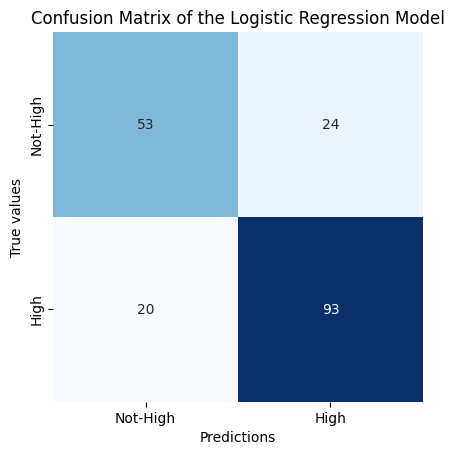

Classification report of the Logistic Regression Model: 
              precision    recall  f1-score   support

           0       0.73      0.69      0.71        77
           1       0.79      0.82      0.81       113

    accuracy                           0.77       190
   macro avg       0.76      0.76      0.76       190
weighted avg       0.77      0.77      0.77       190



In [46]:
best_logistic_model = logistic_grid_search.best_estimator_
print("Best hyperparameters:", logistic_grid_search.best_params_)

# Predicting using the best model founded
y_pred_logistic = best_logistic_model.predict(scaled_X_test)

# Calculating accuracy
accuracy = accuracy_score(y_test, y_pred_logistic)
print("Accuracy of the Logistic Regression Model:", accuracy)

cm = confusion_matrix(y_test, y_pred_logistic)
# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, square=True,
            xticklabels=['Not-High', 'High'],
            yticklabels=['Not-High', 'High'])

plt.xlabel('Predictions')
plt.ylabel('True values')
plt.title('Confusion Matrix of the Logistic Regression Model')

plt.show()
print('Classification report of the Logistic Regression Model: ')
print(classification_report(y_test, y_pred_logistic))

#### KNN

In [47]:
knn_model = KNeighborsClassifier()

param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree'],
    'p': [1, 2]
}
knn_grid_search = GridSearchCV(estimator=knn_model, param_grid=param_grid, scoring='accuracy', cv=10)
knn_grid_search.fit(scaled_X_train, y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree'],
                         'n_neighbors': [3, 5, 7, 9], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

Best hyperparameters: {'algorithm': 'auto', 'n_neighbors': 9, 'p': 1, 'weights': 'distance'}
Accuracy of the KNN Model: 0.6894736842105263


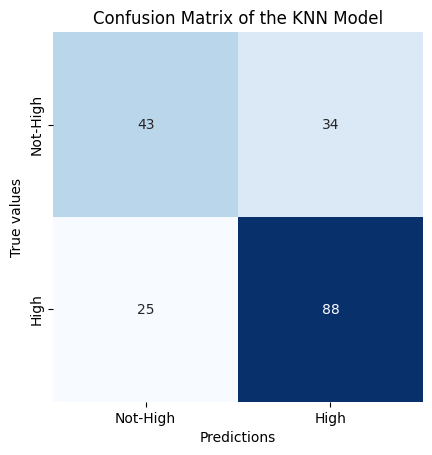

Classification report of the KNN Model: 
              precision    recall  f1-score   support

           0       0.63      0.56      0.59        77
           1       0.72      0.78      0.75       113

    accuracy                           0.69       190
   macro avg       0.68      0.67      0.67       190
weighted avg       0.69      0.69      0.69       190



In [48]:
best_knn_model = knn_grid_search.best_estimator_
print("Best hyperparameters:", knn_grid_search.best_params_)

# Predicting using the best model founded
y_pred_knn = best_knn_model.predict(scaled_X_test)

# Calculating accuracy
accuracy = accuracy_score(y_test, y_pred_knn)
print("Accuracy of the KNN Model:", accuracy)

cm = confusion_matrix(y_test, y_pred_knn)
# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, square=True,
            xticklabels=['Not-High', 'High'],
            yticklabels=['Not-High', 'High'])

plt.xlabel('Predictions')
plt.ylabel('True values')
plt.title('Confusion Matrix of the KNN Model')

plt.show()
print('Classification report of the KNN Model: ')
print(classification_report(y_test, y_pred_knn))

#### SVC

In [49]:
svm_model = SVC()

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'degree': [2, 3, 4],
    'gamma': ['scale', 'auto'],
    'shrinking': [True, False],
    'random_state': [42]
}
svm_grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, scoring='accuracy', cv=10)
svm_grid_search.fit(scaled_X_train, y_train)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'degree': [2, 3, 4],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf', 'poly'],
                         'random_state': [42], 'shrinking': [True, False]},
             scoring='accuracy')

Best hyperparameters: {'C': 0.1, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear', 'random_state': 42, 'shrinking': True}
Accuracy of the KNN Model: 0.7631578947368421


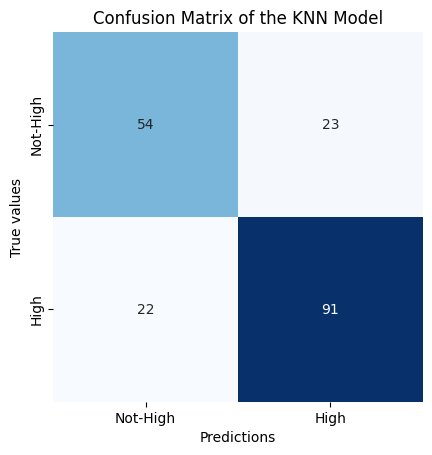

Classification report of the KNN Model: 
              precision    recall  f1-score   support

           0       0.71      0.70      0.71        77
           1       0.80      0.81      0.80       113

    accuracy                           0.76       190
   macro avg       0.75      0.75      0.75       190
weighted avg       0.76      0.76      0.76       190



In [50]:
best_svm_model = svm_grid_search.best_estimator_
print("Best hyperparameters:", svm_grid_search.best_params_)

# Predicting using the best model founded
y_pred_svm = best_svm_model.predict(scaled_X_test)

# Calculating accuracy
accuracy = accuracy_score(y_test, y_pred_svm)
print("Accuracy of the KNN Model:", accuracy)

cm = confusion_matrix(y_test, y_pred_svm)
# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, square=True,
            xticklabels=['Not-High', 'High'],
            yticklabels=['Not-High', 'High'])

plt.xlabel('Predictions')
plt.ylabel('True values')
plt.title('Confusion Matrix of the KNN Model')

plt.show()
print('Classification report of the KNN Model: ')
print(classification_report(y_test, y_pred_svm))

Our primary focus is on accuracy and recall (over High traffic) metrics. Additionally, the confusion matrix was employed to assess the model's performance. Consequently, I have chosen two models based on their superior performance in these metrics – one for the highest accuracy with good recall and the other for the highest recall with good accuracy. The two selected models trained earlier are Gradient Boosting and Logistic Regression. 

The Gradient Boosting model achieves an accuracy of 74% and a recall score of 86%. The 86% recall score indicates that the model accurately predicts high traffic 86% of the time. However, accuracy is also crucial since we aim to minimize misclassifications, especially distinguishing between 'Not-High' and 'High' traffic recipes.
The logistic model achieves an accuracy of 77% and a recall score of 82%. While this model shows a slightly lower performance in identifying 'High' traffic recipes, it demonstrates a slightly better performance in accurately distinguishing between 'Not-High' and 'High' traffic recipes.  

# Business Impact

**Business Objectives**

The primary business objectives are twofold: 
1. Identify which recipes will lead to high traffic. 
2. Correctly predict high traffic recipes 80% of the time.


Both selected models meet the business requirement of being good predictors for high traffic recipes. However, the logistic regression model not only achieves the required recall but also exhibits better accuracy compared to the Gradient Boosting model. Consequently, I have chosen the logistic regression model as the primary machine learning solution for the business.

## Key Performance Indicators (KPIs)

To continuously monitor adherence to business requirements and assess model performance, we propose using accuracy and recall score metrics as key performance indicators (KPIs). Additionally, we recommend monitoring the ROC curve for this purpose.

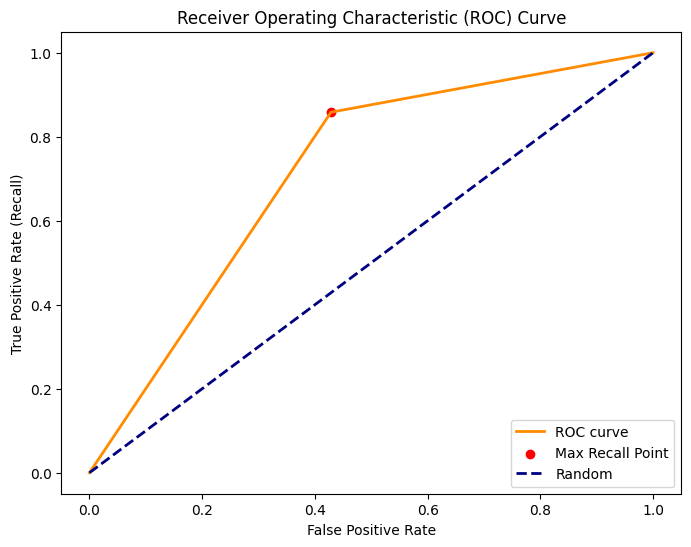

Max Recall: 0.86 at FPR: 0.43


In [53]:
# Computing ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_gb)

# Computing area under the curve (AUC)
roc_auc = auc(fpr, tpr)

# Calculating the recall score
distance_to_top_left = np.sqrt((1 - tpr)**2 + fpr**2)
index_of_max_recall = np.argmin(distance_to_top_left)
max_recall = tpr[index_of_max_recall]
fpr_at_max_recall = fpr[index_of_max_recall]

# Plot ROC curve and recall score
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
plt.scatter(fpr_at_max_recall, max_recall, color='red', label='Max Recall Point')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

print(f'Max Recall: {max_recall:.2f} at FPR: {fpr_at_max_recall:.2f}')

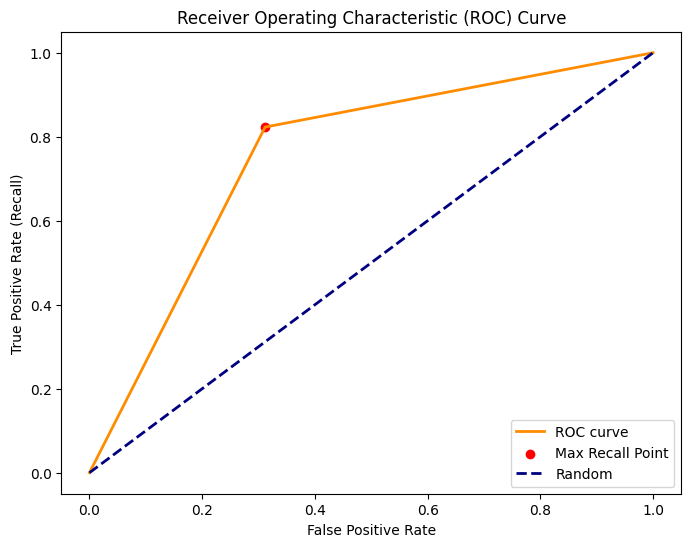

Max Recall: 0.82 at FPR: 0.31


In [54]:
# Computing ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_logistic)

# Computing area under the curve (AUC)
roc_auc = auc(fpr, tpr)

# Calculating the recall score
distance_to_top_left = np.sqrt((1 - tpr)**2 + fpr**2)
index_of_max_recall = np.argmin(distance_to_top_left)
max_recall = tpr[index_of_max_recall]
fpr_at_max_recall = fpr[index_of_max_recall]

# Plot ROC curve and recall score
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
plt.scatter(fpr_at_max_recall, max_recall, color='red', label='Max Recall Point')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

print(f'Max Recall: {max_recall:.2f} at FPR: {fpr_at_max_recall:.2f}')

# Recommendation for Business Strategy

1. **Expand the category variables in the dataset:** Classifying recipes into healthy and unhealthy categories to discern customer preferences for the purpose of creating targeted marketing strategies.
2. **Increase the number of recipes in the most influential recipe categories for high traffic in each serving category:** Since recipes with higher traffic are centered around 4 servings, it is proposed to increase the number of recipes for 4 servings, particularly in the Vegetable, One Dish Meal, and Pork categories. However, it is advisable not to overlook the expansion of recipes in other serving categories, specifically considering the recipe categories identified earlier for each serving category.
3. **Enhance the description of nutritional components in the recipes:** Increase the nutritional description of recipes (such as water content, alcohol, total fat, fiber, cholesterol, etc.) to make it appealing and descriptive for customers, identifying their preference trends. Additionally, these nutritional descriptions will serve as features to enhance the model's performance with appropriate preprocessing.
4. **Deploy the model:** Deploy the recommended model into production to accurately identify recipes that will generate high traffic on the website. 
5. **Ongoing Oversight and Adjustment:** Establish a routine of continuous monitoring and adjustment to align operations with evolving user preferences. Regularly updating the Logistic Regression model with the latest data ensures the website stays in tune with dynamic trends, fostering opportunities for sustained growth and heightened user satisfaction.

## Continuous Monitoring and Improved Model Suggestions

1. **Maintain Continuous KPI and ROC Curve Monitoring:** It is regularly advised to assess the model's performance by observing the ROC curve, along with the metrics defined for the KPIs. 
2. **Continue Monitoring Metric Thresholds:** To choose the optimal recipes for the website and pursue further advancement, it is recommended to begin with a ROC-AUC threshold (accuracy) of at least 70% and a recall score of at least 80%. As the quantity of data in the dataset increases and the quality of features that discriminate between 'High' and 'Not-High' traffic improves, these thresholds will progressively increase.
3. **Continue Updating the Secondary Model:** Due to the challenge of predicting which metric will result in better model performance in the future, it is recommended to keep the Gradient Boosting model as a secondary option. Frequent updates with new data can be performed to compare both models in the future.
